In [172]:
import pickle, math
import ast, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.font_manager as font_manager
import matplotlib.colors as colors
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from scipy.spatial.distance import pdist, squareform
from scipy.stats import linregress, mannwhitneyu, kruskal
from statsmodels.stats.multitest import multipletests
from sklearn.decomposition import PCA
from mpl_toolkits.axes_grid1 import make_axes_locatable
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 50)

In [295]:
### as with all of these, the first time you run, set save to True and processed to False, then switch after
processed = False
save = True
pickle_import = pickle.load(open('./processed_sorted_indiv_building_data_new.pkl', 'rb'))
sorted_b_7,sorted_b_61,sorted_b_84 = pickle_import['sorted_b_7'],pickle_import['sorted_b_61'],pickle_import['sorted_b_84']
combined_data = pd.concat([sorted_b_7,sorted_b_61,sorted_b_84], axis=0)
### NOTE IF YOU JUST ARE COMING FROM XCMS / OTHER SCRIPTS CHANGE INDEX COL TO 0
### and for all other scripts
if processed:
    peaks_data_og_with_metab = pd.read_csv('./stability_added_partly_cleaned_metals_combined_mz_rt_metfrag_votes_isotopes_mzrt_noname_new.csv', index_col=0)
else:
    peaks_data_og_with_metab = pd.read_csv('./partly_cleaned_metals_combined_mz_rt_metfrag_votes_isotopes_mzrt_named_new.csv', index_col=0)

In [65]:
## databases for looking up metab class
db_path = '/home/ubuntu/data/mz_to_metab_mapping/'
dbs_name = {'chebi':'chebi_metabolites.pkl','hmdb':'hmdb_metabolites.pkl',
       'lipidmap':'lipidmap_metabolites.pkl','metacyc':'metacyc_metabolites.pkl'}
dbs = {'chebi':None,'hmdb':None,'lipidmap':None,'metacyc':None, 
       'lipid_msms':None, 'hmdb_msms':None, 'kegg_msms':None}
for db in dbs_name:
    db_ = pickle.load(open(os.path.join(db_path,dbs_name[db]), 'rb'))
    db_lc = {k.lower():v for k,v in db_.items() if type(k)==str}
    dbs[db] = db_lc

inchi_lookups = {'hmdb':None, 'lipidmap':None}
for ele in ['hmdb', 'lipidmap']:
    db = dbs[ele]
    new_db = {}
    for ent in db:
        new_db[db[ent]['inchikey']] = db[ent]
    inchi_lookups[ele] = new_db
    
extra_db_path = '/home/ubuntu/data/mz_to_metab_mapping/msms_pipeline_analysis/essentials/'
csv_dbs = ['lipidmaps.csv','kegg_2017-07-23.csv']
for db_name, csv in zip(['lipid_msms','kegg_msms'], csv_dbs): 
    msms_db = open(os.path.join(extra_db_path, csv), 'r')
    new_db = {}
    for line in msms_db:
        line = line.strip().split('","')
        if db_name == 'lipid_msms':
            new_db[line[0][1:].lower()] = {'mass':line[1],'formula':line[3],'class':line[5], 'sub_class':line[6],
                                           'inchi':line[8][6:], 'inchikey':'-'.join([line[9],line[10],line[12]])}
    dbs[db_name] = new_db



In [228]:
def accession_to_name(dbs):
    acc_to_name = {}
    for ele in dbs['hmdb']:
        for acc in dbs['hmdb'][ele]['hmdb_accession']:
            acc_to_name[acc] = ele
    return acc_to_name

def inchikey_to_name(dbs):
    inchi_to_name = {}
    for ele in dbs['hmdb']:
        inchikey = dbs['hmdb'][ele]['inchikey']
        inchi_to_name[inchikey] = ele
    return inchi_to_name

def inchi_to_name(dbs):
    inchi_to_name = {}
    for ele in dbs['hmdb']:
        inchi = dbs['hmdb'][ele]['inchi']
        inchi_to_name[inchi] = ele
    return inchi_to_name

### get the accessions matching to HMDB names:
acc_to_name_hmdb = accession_to_name(dbs)
### get the inchikey to name for HMDB:
inchikey_to_name_hmdb = inchikey_to_name(dbs)
### get the inchi to name for HMDB:
inchi_to_name_hmdb = inchi_to_name(dbs)

In [333]:
## class / sub_class / type analysis for stable and nonstable
## idea: take the labels, look up the compound in df, take the name and look into the DBs
def get_names(inds, name_df):
    names = list(name_df.loc[inds,'metfrag_matched_best_guess'].values)
    names_w_inds = [[n,i] for n,i in zip(names,inds)]
    total = len(names_w_inds)
    names_w_inds = [ele for ele in names_w_inds if 'Da/' not in ele[0]]
    num_remaining = len(names)
    removed = total - num_remaining
    names = [ast.literal_eval(ele[0]) for ele in names_w_inds]
    inds = [ele[1] for ele in names_w_inds]
    new_names = []
    new_inds = []
    for group,ind in zip(names,inds):
        new_group = []
        for chem in group:
            if len(chem) == 4 and 'C13' in chem[2]:
                continue
            if '**' in chem[0]:
                new_group.append(chem[0][:-2].lower())
            else:
                new_group.append(chem[0].lower())
        if len(new_group) == 0:
            num_remaining -= 1
            removed += 1
        else:
            new_names.append(new_group)
            new_inds.append(ind)
    return new_names, new_inds

def db_name_look_up(name, dbs):
    ### lipidmaps category = hmdb class
    ### lipidmaps main class = hmdb subclass
    ### lipidmaps sub class = hmdb direct parent
    db_info = []
    for db in ['hmdb','lipidmap', 'lipid_msms', 'chebi', 'metacyc']:
        db_info_ = []                
        try:
            chem = dbs[db][name]
            if db == 'hmdb':
                cats = ['class', 'sub_class', 'direct_parent']
            else:
                if chem['hmdb'] != None:
                    try:
                        if type(chem['hmdb']) == list:
                            for acc in chem['hmdb']:
                                try:
                                    hmdb_name = acc_to_name_hmdb[acc]
                                    chem = dbs['hmdb'][hmdb_name]
                                    cats = ['class', 'sub_class', 'direct_parent']
                                    break
                                except:
                                    pass
                        else:
                            hmdb_name = acc_to_name_hmdb[chem['hmdb']]
                            chem = dbs['hmdb'][hmdb_name]
                            cats = ['class', 'sub_class', 'direct_parent']
                    except:
                        try:
                            hmdb_name = inchikey_to_name_hmdb[chem['inchikey']]
                            chem = dbs['hmdb'][hmdb_name]
                            cats = ['class', 'sub_class', 'direct_parent']
                        except:
                            try:
                                hmdb_name = inchi_to_name_hmdb[chem['inchi']]
                                chem = dbs['hmdb'][hmdb_name]
                                cats = ['class', 'sub_class', 'direct_parent']
                            except:
                                cats = ['category','class','sub_class','super_class','inchikey','inchi']
                else:
                    try:
                        hmdb_name = inchikey_to_name_hmdb[chem['inchikey']]
                        chem = dbs['hmdb'][hmdb_name]
                        cats = ['class', 'sub_class', 'direct_parent']
                    except:
                        try:
                            hmdb_name = inchi_to_name_hmdb[chem['inchi']]
                            chem = dbs['hmdb'][hmdb_name]
                            cats = ['class', 'sub_class', 'direct_parent']
                        except:
                            cats = ['category','class','sub_class','super_class','inchikey','inchi']
            for ele in cats:
                try:
                    if type(chem[ele]) == list:
                        db_info_.append(chem[ele][0])
                    else:
                        db_info_.append(chem[ele])
                except:
                    db_info_.append(None)
            if len(db_info_) > 3:
                db_info_ = []
                try:
                    db_info_.append(chem['category'])
                    db_info_.append(chem['class'])
                    db_info_.append(chem['sub_class'])
                except:
                    db_info_.append(None)
            if set(db_info_) == set([None]):
                continue
            if db_info_ not in db_info:
                db_info.append(db_info_)
                break
        except:
            pass
    return db_info

def names_lookup(names_list, dbs):
    name_to_groups = {}
    for i, group in enumerate(names_list):
        group_info = []
        for chem in group:
            db_info = db_name_look_up(chem, dbs)
            if len(db_info) == 0:
                continue
            elif db_info[0] in group_info:
                continue
            else:
                group_info += db_info
        name_to_groups[i] = group_info
    return name_to_groups

def make_hist(list_of_names):
    h = {}
    for ele in list_of_names:
        if ele not in h:
            h[ele] = 1
        else:
            h[ele] += 1
    return h

def get_best_name(names, priority='middle'):
    l1 = names[0]
    l2 = names[1]
    l3 = names[2]
    if priority == 'last':
        if l3 == None:
            if l2 == None:
                return l1
            else:
                return l2
        return l3
    elif priority == 'middle':
        if l2 == None:
            return l1
        else:
            return l2
    elif priority == 'first':
        return l1

def chart_metab_classes(class_to_count, title, priority):
    heights = list(class_to_count.values())
    labels = list(class_to_count.keys())
    fig = plt.figure(figsize=(5,5))
    ax = plt.subplot()
    y = [i for i in range(len(labels))]
    ax.barh(y, heights,color='c', edgecolor='k', linewidth=0.5)
    ax.set_yticks(y)
    ax.set_yticklabels(labels)
    ax.set_ylim([-0.5,len(labels)-0.5])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel('Class counts', fontname='sans-serif', fontsize=12)
    ax.set_title(title+' '+priority, fontname='sans-serif', fontsize=14)
        
    if save:
        plt.savefig('metab_types_{}_{}.svg'.format('_'.join(title.split(' ')),'_'.join(priority.split(' '))), format='svg', dpi=1000, bbox_inches='tight')
    plt.show()

def get_max_classes(class_dict, x):
    list_d = sorted([(k,v) for k,v in class_dict.items()],key=lambda x:x[1], reverse=True)
    top_dict = {kv[0]:kv[1] for kv in list_d[:x]}
    return top_dict

In [111]:
# ok now what happens when you start to seperate the data out into different levels of standard deviation
# take a building data in, seperate out high and low variance features. 
def get_cutoff_data(building, peaks_data, cutoff, cv=False, plot=False):
    '''
    purpose of this function is to split up the data for a given building by those features with standard 
    deviations above a cutoff and those below. you can also plot
    input:
        building: sorted pd df of the building data:
        peaks_data: the filtered mz/rt peak df
        cuttoff: the std cutoff to split the data on
    out:
        b_data_lt: df of the features with std less than the cutoff
        b_data_gt: df of the features with std greater than the cutoff
        peaks_data_lt: df of the peaks which correspond to the mz features with stds less than the cutoff
        peaks_data_gt: df of the peaks which correspond to the mz features with stds greater than the cutoff
    '''
    b_mean = building.mean(axis=0)
    b_std = building.std(axis=0)
    if cv:
        cutoff = 0.3
        b_col_lt = list(building.columns[list(b_std/b_mean < cutoff)])
        b_col_gt = list(building.columns[list(b_std/b_mean >= cutoff)])
    else:
        cutoff = cutoff
        b_col_lt = list(building.columns[list(b_std < cutoff)])
        b_col_gt = list(building.columns[list(b_std >= cutoff)])
    # masking the full dataframe by these to plot the scattermaps....
    b_data_lt = building[b_col_lt]
    b_data_gt = building[b_col_gt]
    peaks_data_lt = peaks_data.loc[b_col_lt]
    peaks_data_gt = peaks_data.loc[b_col_gt]
    if plot:
        plt.matshow(b_data_lt.values)
        plt.colorbar()
        plt.gca().set_aspect('auto')
        plt.show()
        cg = sns.clustermap(b_data_lt)
        plt.show()
        plt.matshow(b_data_gt.values)
        plt.colorbar()
        plt.gca().set_aspect('auto')
        plt.show()
        cg = sns.clustermap(b_data_gt)
        plt.show()
    return b_data_lt, b_data_gt, peaks_data_lt, peaks_data_gt

cutoff = 2
b_7_data_lt, b_7_data_gt, peaks_b_7_data_lt, peaks_b_7_data_gt = get_cutoff_data(sorted_b_7, peaks_data_og_with_metab, cutoff, cv=False)
b_61_data_lt, b_61_data_gt, peaks_b_61_data_lt, peaks_b_61_data_gt = get_cutoff_data(sorted_b_61, peaks_data_og_with_metab, cutoff, cv=False)
b_84_data_lt, b_84_data_gt, peaks_b_84_data_lt, peaks_b_84_data_gt = get_cutoff_data(sorted_b_84, peaks_data_og_with_metab, cutoff, cv=False)

634


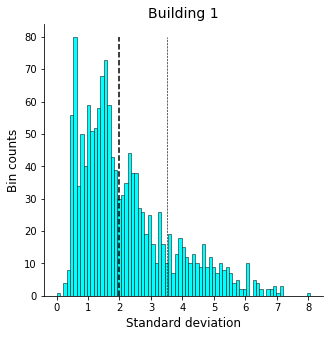

570


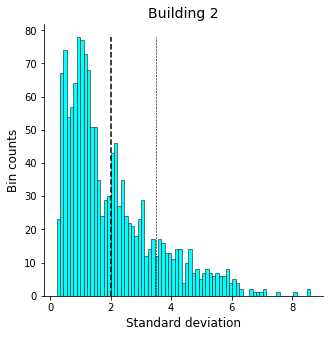

457


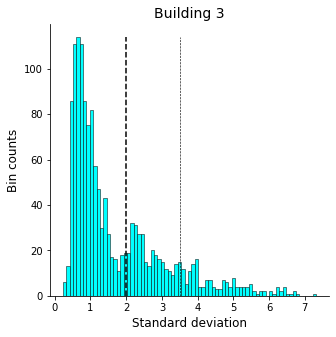

In [112]:
# looking at distribution of the standard deviations to find a cutoff value for stable and nonstable
def get_cutoff_data(building, peaks_data, title,ct):
    b_mean = building.mean(axis=0)
    b_std = building.std(axis=0)
    num_gt_ct = b_std[b_std>ct].count()
    print(num_gt_ct)
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
    n,_,_ = ax.hist(b_std, bins=75,facecolor='cyan', edgecolor='black', linewidth=0.5)
    ax.plot([ct,ct],[0,n.max()], 'k--')
    ax.plot([3.5,3.5],[0,n.max()], 'k--', linewidth=0.6)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title(title,fontname='sans-serif', fontsize=14)
    ax.set_xlabel('Standard deviation',fontname='sans-serif', fontsize=12)
    ax.set_ylabel('Bin counts',fontname='sans-serif', fontsize=12)
    if save:
        plt.savefig('Std_dev_cutoff_{}_{}.svg'.format(ct,'_'.join(title.split())), format='svg', dpi=1000, bbox_inches='tight')
    plt.show()

get_cutoff_data(sorted_b_7, peaks_data_og_with_metab, 'Building 1', cutoff)
get_cutoff_data(sorted_b_61, peaks_data_og_with_metab,'Building 2', cutoff)
get_cutoff_data(sorted_b_84, peaks_data_og_with_metab,'Building 3', cutoff)

In [113]:
#### check to make sure sizes are correct 
print(b_7_data_lt.shape, b_7_data_gt.shape, b_7_data_lt.shape[1]+b_7_data_gt.shape[1])
print(b_61_data_lt.shape, b_61_data_gt.shape, b_61_data_lt.shape[1]+b_61_data_gt.shape[1])
print(b_84_data_lt.shape, b_84_data_gt.shape, b_84_data_lt.shape[1]+b_84_data_gt.shape[1])

(22, 791) (22, 634) 1425
(25, 855) (25, 570) 1425
(23, 968) (23, 457) 1425


In [114]:
##### add new columns to the df with names and masses that says whether a metabolite is stabile in a building or not
##### 1 = stable, 0 = not
if not processed:
    zero_list = [0 for i in range(peaks_data_og_with_metab.shape[0])]
    peaks_data_og_with_metab['stable_b7'] = zero_list
    peaks_data_og_with_metab['stable_b61'] = zero_list
    peaks_data_og_with_metab['stable_b84'] = zero_list
    for stab_in_b, building in zip([peaks_b_7_data_lt, peaks_b_61_data_lt, peaks_b_84_data_lt], ['stable_b7', 'stable_b61','stable_b84']):
        stab_to_add = list(stab_in_b.index)
        peaks_data_og_with_metab.loc[stab_to_add, building] = 1

0: n-decanoylglycine, 1: 237.93104Da/209.2619s, 2: girgensonine, 3: n-lauroylglycine, 4: 257.19547Da/491.08835s, 5: rhombifoline, 6: 4'-n-desmethylolanzapine, 7: 320.19064Da/475.77286, 8: 6-keto-decanoylcarnitine, 9: 445.04309Da/48.8418s
0: 226.86214Da/33.24614s, 1: n-decanoylglycine, 2: 237.93104Da/209.2619s, 3: girgensonine, 4: n-lauroylglycine, 5: 257.19547Da/491.08835s, 6: rhombifoline, 7: acetylsulfamethoxazole/n4-acetylsulfamethoxazole, 8: 4'-n-desmethylolanzapine, 9: 1-[(3-chlorophenyl)methyl]-N,N-diethyl-3-piperidinecarboxamide^, 10: 320.19064Da/475.77286, 11: 6-keto-decanoylcarnitine, 12: 445.04309Da/48.8418s
0: 226.86214Da/33.24614s


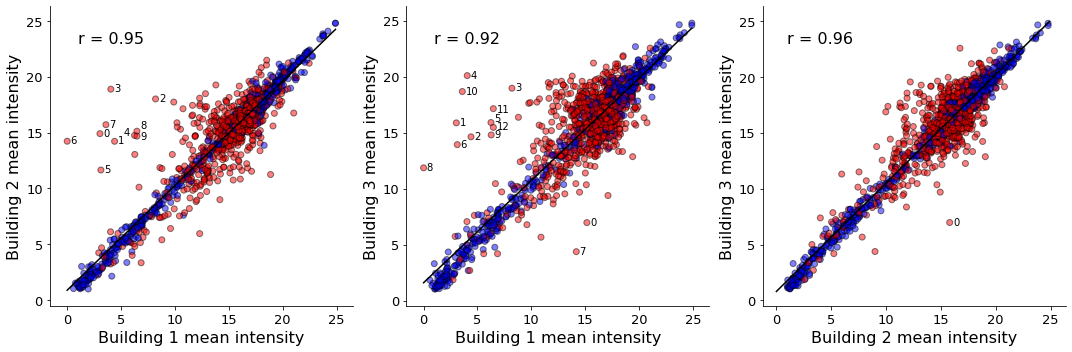

In [115]:
##### find the means and standard deviations of metabolites 
#####    use this to seperate high variance from low variance metabolites
# data to play with: sorted_b_7, sorted_b_84 and sorted_b_61
# each row is a sample, each column a mz feat --> calc mean and set on axis 0

def large_mean_diff(b1m, b2m, ct=8):
    diff = b1m - b2m
    diff = diff.abs()
    diff = diff[diff>ct]
    return diff    

def get_name_for_paper(diff_names):
    text = []
    for i, name in enumerate(diff_names):
        if 'Da/' in name:
            text.append((i,name))
        else:
            name = ast.literal_eval(name)
            n = []
            for ele in name:
                if ele[0][-2:]=='**':
                    n.append(ele[0][:-2]+'^')
                else:
                    n.append(ele[0])
            n = '/'.join(n)
            text.append((i,n))
    text = [str(ele[0])+': '+ele[1] for ele in text]
    text = ', '.join(text)
    print(text)
    
b_7_mean = sorted_b_7.mean(axis=0)
b_7_std = sorted_b_7.std(axis=0)
b_61_mean = sorted_b_61.mean(axis=0)
b_61_std = sorted_b_61.std(axis=0)
b_84_mean = sorted_b_84.mean(axis=0)
b_84_std = sorted_b_84.std(axis=0)

b7_61_diff_large = large_mean_diff(b_7_mean,b_61_mean)
b7_61_diff_means = [b_7_mean.loc[b7_61_diff_large.index], b_61_mean.loc[b7_61_diff_large.index]]
b7_61_diff_names = peaks_data_og_with_metab.loc[b7_61_diff_large.index,'metfrag_matched_best_guess']
b7_84_diff_large = large_mean_diff(b_7_mean,b_84_mean)
b7_84_diff_means = [b_7_mean.loc[b7_84_diff_large.index], b_84_mean.loc[b7_84_diff_large.index]]
b7_84_diff_names = peaks_data_og_with_metab.loc[b7_84_diff_large.index,'metfrag_matched_best_guess']
b61_84_diff_large = large_mean_diff(b_61_mean,b_84_mean)
b61_84_diff_means = [b_61_mean.loc[b61_84_diff_large.index], b_84_mean.loc[b61_84_diff_large.index]]
b61_84_diff_names = peaks_data_og_with_metab.loc[b61_84_diff_large.index,'metfrag_matched_best_guess']

get_name_for_paper(b7_61_diff_names)
get_name_for_paper(b7_84_diff_names)
get_name_for_paper(b61_84_diff_names)


# get the high standard dev metabs to show the off diag ones are due to this...
for_color_b_7_61 = [any(a) for a in zip(list(b_61_std >= cutoff), list(b_7_std >= cutoff))]
for_color_b_7_84 = [any(a) for a in zip(list(b_84_std >= cutoff), list(b_7_std >= cutoff))]
for_color_b_61_84 = [any(a) for a in zip(list(b_61_std >= cutoff), list(b_84_std >= cutoff))]
for_color_b_7_61_84 = [any(a) for a in zip(list(b_61_std >= cutoff), list(b_84_std >= cutoff), list(b_7_std >= cutoff))]

for_color_b_7_61 = ['r' if ele == True else 'b' for ele in for_color_b_7_61]
for_color_b_7_84 = ['r' if ele == True else 'b' for ele in for_color_b_7_84]
for_color_b_61_84 = ['r' if ele == True else 'b' for ele in for_color_b_61_84]
for_color_b_7_61_84 = ['r' if ele == True else 'b' for ele in for_color_b_7_61_84]

# for the correlation of the means
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(131)
ax1.set_xlabel('Building 1 mean intensity',fontname='sans-serif', fontsize=16)
ax1.set_ylabel('Building 2 mean intensity',fontname='sans-serif', fontsize=16)
for i,ele in enumerate(list(b7_61_diff_names.index)):
    x,y = b7_61_diff_means[0].loc[ele], b7_61_diff_means[1].loc[ele]
    t = i
    if i==4:
        x -= 1
    elif i==8:
        y += 0.3
        x+= 0.3
    elif i==9:
        y-= 0.3
        x+= 0.3
    else:
        x+= 0.3
        y-= 0.2
    ax1.text(x,y,t)
slope,inter,r,p,_ = linregress(b_7_mean,b_61_mean)
xs = list(np.arange(0,int(list(sorted(b_7_mean))[-1]+1), 0.1))
ys = slope*np.asarray(list(np.arange(0,int(list(sorted(b_7_mean))[-1]+1),0.1)))+inter
plt.plot(xs,ys, c='k')
plt.text(1,23, 'r = {:.2f}'.format(r),fontname='sans-serif', fontsize=16)
plt.scatter(b_7_mean,b_61_mean, c=for_color_b_7_61, alpha=0.5,edgecolors='k')
ax2 = fig.add_subplot(132)
ax2.set_xlabel('Building 1 mean intensity',fontname='sans-serif', fontsize=16)
ax2.set_ylabel('Building 3 mean intensity',fontname='sans-serif', fontsize=16)
for i,ele in enumerate(list(b7_84_diff_names.index)):
    x,y = b7_84_diff_means[0].loc[ele], b7_84_diff_means[1].loc[ele]
    t = i
    if i==5:
        x += 0.3
        y += 0.15
    elif i==13:
        y -= 0.4
        x += 0.3
    elif i==11:
        y-= 0.3
        x+= 0.3
    else:
        x+= 0.3
        y-= 0.2
    ax2.text(x,y,t)
slope,inter,r,p,_ = linregress(b_7_mean,b_84_mean)
xs = list(np.arange(0,int(list(sorted(b_7_mean))[-1]+1), 0.1))
ys = slope*np.asarray(list(np.arange(0,int(list(sorted(b_7_mean))[-1]+1),0.1)))+inter
plt.plot(xs,ys, c='k')
plt.text(1,23, 'r = {:.2f}'.format(r),fontname='sans-serif', fontsize=16)
plt.scatter(b_7_mean,b_84_mean, c=for_color_b_7_84, alpha=0.5,edgecolors='k')
ax3 = fig.add_subplot(133)
ax3.set_xlabel('Building 2 mean intensity',fontname='sans-serif', fontsize=16)
ax3.set_ylabel('Building 3 mean intensity',fontname='sans-serif', fontsize=16)
for i,ele in enumerate(list(b61_84_diff_names.index)):
    x,y = b61_84_diff_means[0].loc[ele], b61_84_diff_means[1].loc[ele]
    t = i
    x+= 0.3
    y-= 0.2
    ax3.text(x,y,t)
slope,inter,r,p,_ = linregress(b_61_mean,b_84_mean)
xs = list(np.arange(0,int(list(sorted(b_61_mean))[-1]+1), 0.1))
ys = slope*np.asarray(list(np.arange(0,int(list(sorted(b_61_mean))[-1]+1),0.1)))+inter
plt.plot(xs,ys, c='k')
plt.text(1,23, 'r = {:.2f}'.format(r),fontname='sans-serif', fontsize=16)
plt.scatter(b_61_mean,b_84_mean, c=for_color_b_61_84, alpha=0.5,edgecolors='k')
for label in (ax1.get_xticklabels() + ax1.get_yticklabels()):
    label.set_fontsize(13)
for label in (ax2.get_xticklabels() + ax2.get_yticklabels()):
    label.set_fontsize(13)
for label in (ax3.get_xticklabels() + ax3.get_yticklabels()):
    label.set_fontsize(13)
for ax in [ax1, ax2, ax3]:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
plt.tight_layout()
if save:
    plt.savefig('Fig1b_new.svg', format='svg', dpi=1000, bbox_inches='tight')
plt.show()

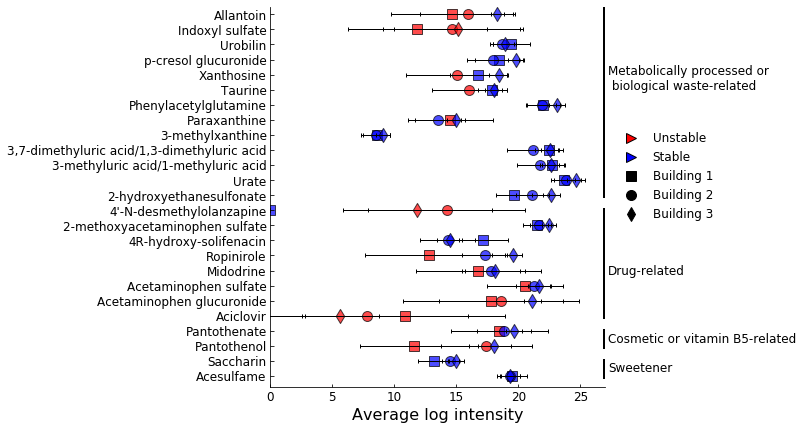

In [60]:
#### look at the highest avg metabolites by intensity...should break down by building....
### use this index order to order the data from the individual buildings to give a common ordering
indicies = [312,460,644,750,783,1368,823,962,1194,1636,996,
            1213,69,355,454,553,340,441,1012,65,1125,1126,1872,702,277]
labels = ['sweetener','sweetener','Pro-vitamin B5','vitamin B5','drug','drug',
          'drug','drug','drug','drug','drug','drug','urine','urine','urine','urine','urine',
          'urine','urine','urine','urine','urine','urine','urine','urine']

means_b_7 = list(sorted_b_7.mean(axis=0).loc[indicies].values)
std_b_7 = list(sorted_b_7.std(axis=0).loc[indicies].values)
c_b_7 = ['b' if ele < 3 else 'r' for ele in std_b_7 ]
s_b_7 = ['s' for ele in c_b_7]
means_b_61 = list(sorted_b_61.mean(axis=0).loc[indicies].values)
std_b_61 = list(sorted_b_61.std(axis=0).loc[indicies].values)
c_b_61 = ['b' if ele < 3 else 'r' for ele in std_b_61]
s_b_61 = ['o' for ele in c_b_61]
means_b_84 = list(sorted_b_84.mean(axis=0).loc[indicies].values)
std_b_84 = list(sorted_b_84.std(axis=0).loc[indicies].values)
c_b_84 = ['b' if ele < 3 else 'r' for ele in std_b_84 ]
s_b_84 = ['d' for ele in c_b_84]
# get the names of the metabs for labels
names = list(peaks_data_og_with_metab.loc[indicies,'metfrag_matched_best_guess'])

data = [[means_b_7,std_b_7,c_b_7,s_b_7],[means_b_61,std_b_61,c_b_61,s_b_61],[means_b_84,std_b_84,c_b_84,s_b_84]]

fig = plt.figure(figsize=(6,7))
ax = plt.gca()
#### get all the data to plot:
ax.get_yaxis().set_ticks([])
ax.set_xlabel('Average log intensity', fontname='sans-serif', fontsize=16)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(direction='in')
for d in data:
    ys = list(range(1,len(d[0])+1))
    xs, xs_err, colors, shapes = d[0], d[1], d[2], d[3]
    for x_,y_,xerr_,s_,c_ in zip(xs,ys,xs_err,shapes,colors):
        ax.scatter(x_, y_, marker=s_, s=100, alpha=0.7, linewidth=1, facecolors=c_, edgecolor='k')
        ax.errorbar(x_,y_,xerr=xerr_,ecolor='k', capsize=2, elinewidth=1.0)    
ax.yaxis.set_ticks(ys)
ax.set_xlim([0,27])
ax.set_ylim([0.25,25.5])
features = []
for f in names:
    try:
        f = ast.literal_eval(f)
        possible_labels = ''
        if len(f) > 1:
            for sub_f in f:
                possible_labels += sub_f[0]
                possible_labels += '/'
            features.append(possible_labels[:-1])
        else:
            features.append(possible_labels.join(f[0][0]))
    except:
        features.append(f)
#### fix a few of the names:
features[3] = 'pantothenate'
features[-1] = 'allantoin'
features[13] = 'urate'
features[18] = 'phenylacetylglutamine'
features[22] = 'urobilin'
features[11] = "4'-N-desmethylolanzapine"
features[9] = '4R-hydroxy-solifenacin'
features[17] = 'Paraxanthine'
features[6] = 'acetaminophen sulfate'
features = [f[0].upper()+f[1:] for f in features]
features[-4] = 'p-cresol glucuronide'
ax.set_yticklabels(features, fontdict={'fontsize': 12, 'fontweight': 'normal'})
for label in (ax.get_xticklabels()):
    label.set_fontsize(12)
ax.plot([27,27],[1,2], 'k', linewidth=5)
ax.plot([27,27],[3,4], 'k', linewidth=5)
ax.plot([27,27],[5,12], 'k', linewidth=5)
ax.plot([27,27],[13,27], 'k', linewidth=5)
ax.text(27.25,1.3, 'Sweetener',fontsize=12)
ax.text(27.25,3.25, 'Cosmetic or vitamin B5-related',fontsize=12)
ax.text(27.25,7.75, 'Drug-related',fontsize=12)
ax.text(27.25,20, 'Metabolically processed or \n biological waste-related',fontsize=12)
#### colors for legend
legend_data = [['Unstable', 'r', 'k', '>'],
               ['Stable', 'b', 'k', '>'],
               ['Building 1', 'k', 'k', 's'],
               ['Building 2', 'k', 'k', 'o'],
               ['Building 3', 'k', 'k', 'd']]
patches_bar = []
for ele in legend_data:
    patches_bar.append(Line2D([0],[0], color='w', marker=ele[3],markerfacecolor=ele[1], markeredgecolor=ele[2], label=ele[0], markersize=10)) 
font = font_manager.FontProperties(family='sans-serif', style='normal', size=12)
lgd = ax.legend(handles=patches_bar, bbox_to_anchor=(1.01, 0.7), frameon=False, prop=font)
if save:
    plt.savefig('Fig1d_new.svg', format='svg', dpi=1000, bbox_inches='tight')

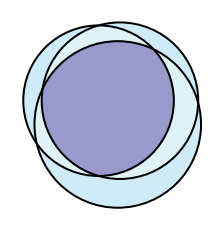

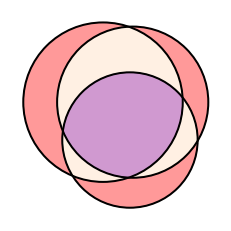

In [62]:
# see the overlap of metabolites between the buildings in the various groups. 
from matplotlib_venn import venn3, venn3_circles
def build_venn3(d1,d2,d3, stype = 'mis', no_label_nums=False):
    all_3 = [value for value in d1 if value in d3 and value in d2]
    d1_2 = [value for value in d1 if value in d2 and value not in all_3]
    d1_3 = [value for value in d1 if value in d3 and value not in all_3]
    d2_3 = [value for value in d2 if value in d3 and value not in all_3]
    d1_n = [value for value in d1 if value not in d2_3 and value not in d1_3 and value not in d1_2 and value not in all_3]
    d2_n = [value for value in d2 if value not in d2_3 and value not in d1_3 and value not in d1_2 and value not in all_3]
    d3_n = [value for value in d3 if value not in d2_3 and value not in d1_3 and value not in d1_2 and value not in all_3]
    ##### uncomment the follow to make the plots:
    v = venn3(subsets = (len(d1_n), len(d2_n), len(d1_2), len(d3_n), len(d1_3), len(d2_3), len(all_3)), set_labels=['','','']) #, set_labels = ('Building 1', 'Building 2', 'Building 3'))
    c = venn3_circles(subsets = (len(d1_n), len(d2_n), len(d1_2), len(d3_n), len(d1_3), len(d2_3), len(all_3)))
    colors = {'unstable':['r','r','r','peachpuff','peachpuff','peachpuff','darkmagenta'],
              'stable':['skyblue','skyblue','skyblue','powderblue','powderblue','powderblue','navy']}
    for i,lab in enumerate(['100','010','001','110','101','011','111']):
        if no_label_nums:
            v.get_label_by_id(lab).set_text("")
            v.get_label_by_id(lab).set_alpha(1)
        if stype == 'stable':
            v.get_patch_by_id(lab).set_color(colors[stype][i])
        elif stype == 'unstable':
            v.get_patch_by_id(lab).set_color(colors[stype][i])
        else:
            pass
    if save:
        plt.savefig('Fig1c_{}_label_nums_{}_new.svg'.format(stype, no_label_nums), format='svg', dpi=1000, bbox_inches='tight')
    plt.show()
    return d1_n, d2_n, d3_n, d1_2, d1_3, d2_3, all_3
    
b_7_lt_col_ids = list(b_7_data_lt.columns)
b_7_gt_col_ids = list(b_7_data_gt.columns)
b_61_lt_col_ids = list(b_61_data_lt.columns)
b_61_gt_col_ids = list(b_61_data_gt.columns)
b_84_lt_col_ids = list(b_84_data_lt.columns)
b_84_gt_col_ids = list(b_84_data_gt.columns)

#### IMPORTANT:
#### this venn is actually really useful, the stuff it return can be used to subset the data!!!!!!
lt_d1_n, lt_d2_n, lt_d3_n, lt_d1_2, lt_d1_3, lt_d2_3, lt_all_3 = build_venn3(b_7_lt_col_ids,b_61_lt_col_ids,b_84_lt_col_ids, stype='stable', no_label_nums=True)
gt_d1_n, gt_d2_n, gt_d3_n, gt_d1_2, gt_d1_3, gt_d2_3, gt_all_3 = build_venn3(b_7_gt_col_ids,b_61_gt_col_ids,b_84_gt_col_ids, stype='unstable', no_label_nums=True)

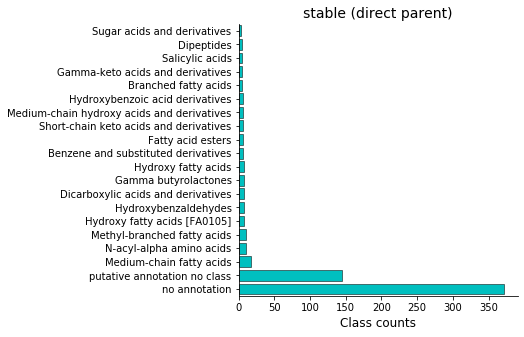

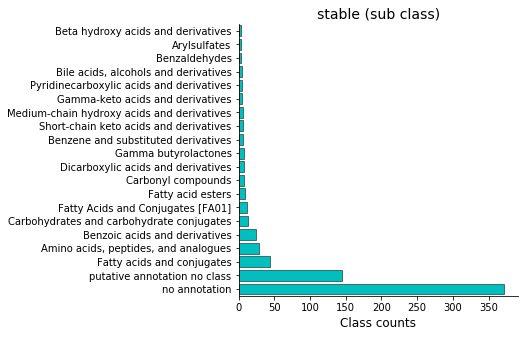

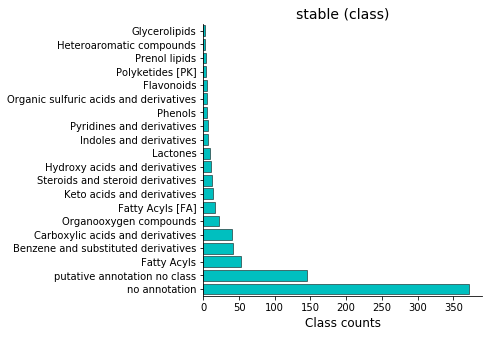

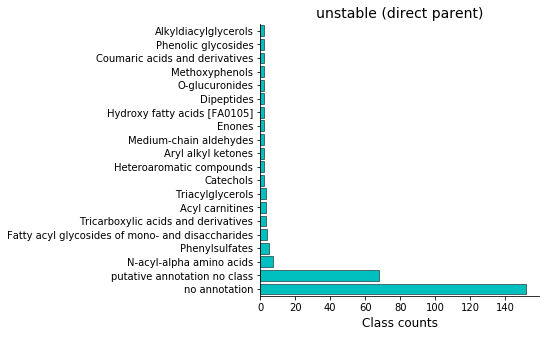

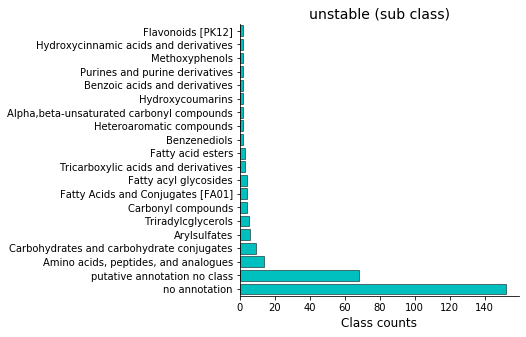

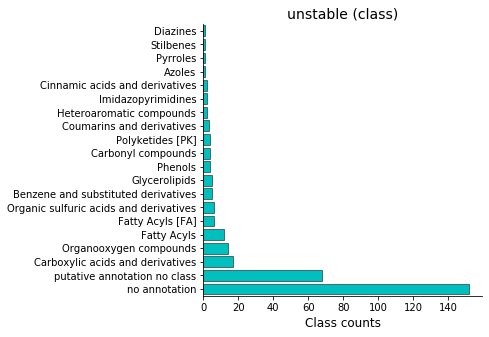

In [241]:
### metab classes in stable v not stable:
for title,inds in zip(['stable','unstable'],[lt_all_3,gt_all_3]):
    stable_inds = list(sorted_b_7[inds].T.index)
    all_comp = list(peaks_data_og_with_metab.loc[stable_inds,'metfrag_matched_best_guess'].values)
    not_annot = [ele for ele in all_comp if 'Da/' in ele]
    names_met_c,s_inds_met_c = get_names(stable_inds, peaks_data_og_with_metab)
    named_groups_met_c = names_lookup(names_met_c, dbs)
    for pri,pri_class in zip(['last', 'middle', 'first'],['(direct parent)', '(sub class)', '(class)']):
        all_groups = {'no annotation':len(not_annot), 'putative annotation no class':0}
        for k,metab_groups in named_groups_met_c.items():
            if 'Da/' not in all_comp[k]:
                all_put_comps = ast.literal_eval(all_comp[k])
                if (len(all_put_comps) != 0 and len(metab_groups) == 0):
                    all_groups['putative annotation no class']+= int(len(all_put_comps)-len(metab_groups))
            for sub_g in metab_groups:
                sub_g_class = get_best_name(sub_g, priority=pri)
                if sub_g_class not in all_groups:
                    all_groups[sub_g_class] = 1
                else:
                    all_groups[sub_g_class] += 1   
        all_groups = get_max_classes(all_groups,20)
        chart_metab_classes(all_groups, title, pri_class)


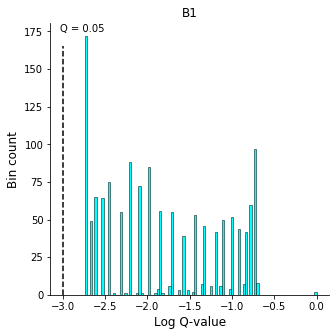

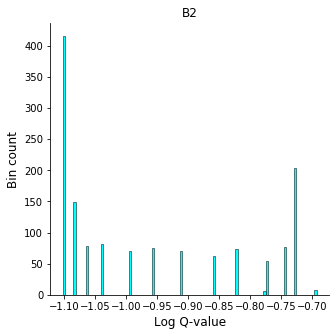

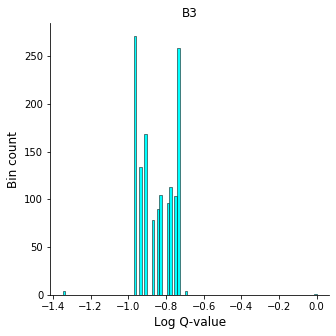

In [63]:
## looking at weekday v. weekend differences...statistically:
# sorted_b_7   sorted_b_61   sorted_b_84
def wed_sat(df):
    inds = list(df.index)
    wed_inds = [ele for ele in inds if 'W_' in ele]
    sat_inds = [ele for ele in inds if 'Sa_' in ele]
    df_w = df.loc[wed_inds]
    df_sat = df.loc[sat_inds]
    return df_w, df_sat

def calc_sig(df_w, df_sat):
    p = np.zeros(df_w.shape[1]) + np.nan
    cols = df_w.columns
    for i,col in enumerate(cols):
        try:
            _,p[i] = mannwhitneyu(df_w[col], df_sat[col])
        except:
            if set(df_w[col]) == set(df_sat[col]):
                p[i] = 1
    _, p[~np.isnan(p)], _, _ = multipletests(p[~np.isnan(p)], alpha=0.00001, method='fdr_bh')
    return p

w_b7, sat_b7 = wed_sat(sorted_b_7)
w_b61, sat_b61 = wed_sat(sorted_b_61)
w_b84, sat_b84 = wed_sat(sorted_b_84)

ps_w_sat_b7 = calc_sig(w_b7, sat_b7)
ps_w_sat_b61 = calc_sig(w_b61, sat_b61)
ps_w_sat_b84 = calc_sig(w_b84, sat_b84)

for b_ps, b in zip([ps_w_sat_b7, ps_w_sat_b61, ps_w_sat_b84],['B1', 'B2', 'B3']):
    fig = plt.figure(figsize=(5,5))
    ax = plt.subplot()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title(b)
    ax.set_xlabel('Log Q-value', fontname='sans-serif', fontsize=12)
    ax.set_ylabel('Bin count', fontname='sans-serif', fontsize=12)
    ax.hist(np.log(b_ps), bins=100, facecolor='cyan', edgecolor='black', linewidth=0.5)
    if b=='B1':
        ax.plot([np.log(0.05), np.log(0.05)],[0,165], 'k--')
        ax.text(np.log(0.048), 175, 'Q = 0.05')
    if save:
        plt.savefig('q-values_wed_vs_sat_{}.svg'.format(b), format='svg', dpi=1000, bbox_inches='tight')
        

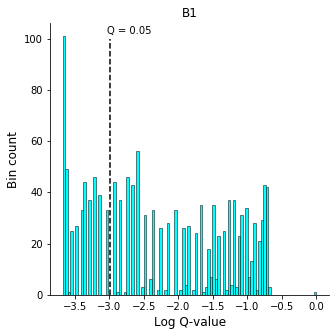

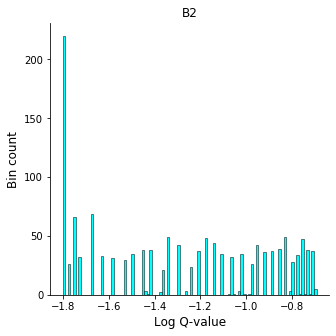

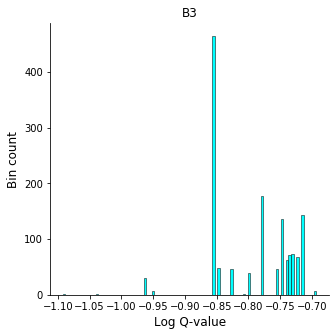

In [64]:
## looking at weekday v. weekend differences...statistically:
# sorted_b_7   sorted_b_61   sorted_b_84
def week_v_weekend(df):
    inds = list(df.index)
    wed_inds = [ele for ele in inds if 'Sa_' not in ele and 'Su_' not in ele]
    sat_inds = [ele for ele in inds if 'Sa_' in ele or 'Su_' in ele]
    df_w = df.loc[wed_inds]
    df_sat = df.loc[sat_inds]
    return df_w, df_sat

def calc_sig(df_w, df_sat):
    p = np.zeros(df_w.shape[1]) + np.nan
    cols = df_w.columns
    for i,col in enumerate(cols):
        try:
            _,p[i] = mannwhitneyu(df_w[col], df_sat[col])
        except:
            if set(df_w[col]) == set(df_sat[col]):
                p[i] = 1
    _, p[~np.isnan(p)], _, _ = multipletests(p[~np.isnan(p)], alpha=0.00001, method='fdr_bh')
    return p

w_b7, end_b7 = week_v_weekend(sorted_b_7)
w_b61, end_b61 = week_v_weekend(sorted_b_61)
w_b84, end_b84 = week_v_weekend(sorted_b_84)

ps_w_we_b7 = calc_sig(w_b7, end_b7)
ps_w_we_b61 = calc_sig(w_b61, end_b61)
ps_w_we_b84 = calc_sig(w_b84, end_b84)

for b_ps, b in zip([ps_w_we_b7, ps_w_we_b61, ps_w_we_b84],['B1', 'B2', 'B3']):
    fig = plt.figure(figsize=(5,5))
    ax = plt.subplot()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title(b)
    ax.set_xlabel('Log Q-value', fontname='sans-serif', fontsize=12)
    ax.set_ylabel('Bin count', fontname='sans-serif', fontsize=12)
    ax.hist(np.log(b_ps), bins=100, facecolor='cyan', edgecolor='black', linewidth=0.5)
    if b=='B1':
        ax.plot([np.log(0.05), np.log(0.05)],[0,100], 'k--')
        ax.text(np.log(0.048), 102, 'Q = 0.05')
    if save:
        plt.savefig('q-values_week_vs_weekend_{}.svg'.format(b), format='svg', dpi=1000, bbox_inches='tight')   

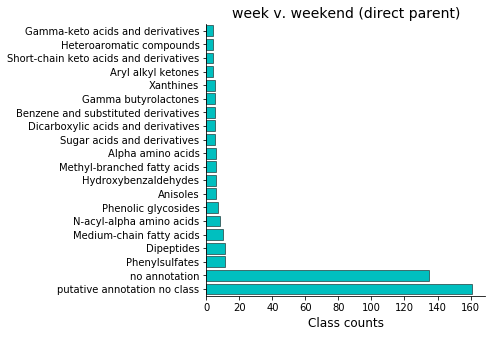

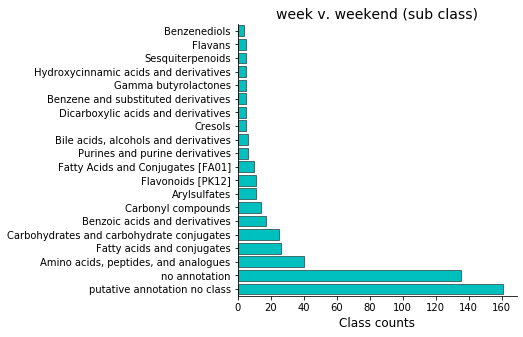

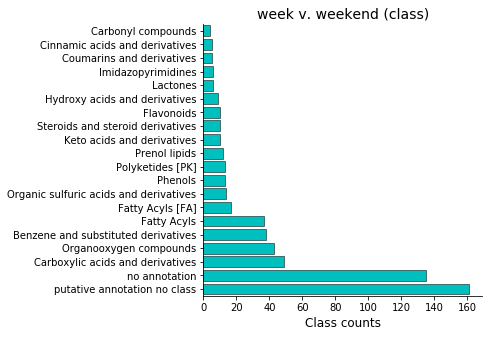

In [239]:
## look at week v. weekend...    
title = 'week v. weekend'
w_we_inds = list(peaks_data_og_with_metab[ps_w_we_b7 < 0.05].index)
### 435 total Q < 0.05
all_comp = list(peaks_data_og_with_metab.loc[w_we_inds,'metfrag_matched_best_guess'].values)
not_annot = [ele for ele in all_comp if 'Da/' in ele]
names_met_c,s_inds_met_c = get_names(w_we_inds, peaks_data_og_with_metab)
named_groups_met_c = names_lookup(names_met_c, dbs)
for pri,pri_class in zip(['last', 'middle', 'first'],['(direct parent)', '(sub class)', '(class)']):
    all_groups = {'no annotation':len(not_annot), 'putative annotation no class':0}
    for k,metab_groups in named_groups_met_c.items():
        if 'Da/' not in all_comp[k]:
            all_put_comps = ast.literal_eval(all_comp[k])
            if (len(all_put_comps) != 0 and len(metab_groups) == 0):
                all_groups['putative annotation no class']+= int(len(all_put_comps)-len(metab_groups))
        for sub_g in metab_groups:
            sub_g_class = get_best_name(sub_g, priority=pri)
            if sub_g_class not in all_groups:
                all_groups[sub_g_class] = 1
            else:
                all_groups[sub_g_class] += 1  
    all_groups = get_max_classes(all_groups,20)
    chart_metab_classes(all_groups, title, pri_class)

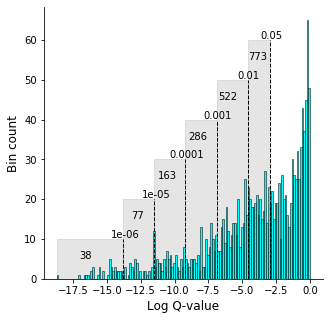

In [329]:
## looking at ALL...even though it says 'stable'...
stable_in_7 = sorted_b_7
stable_in_61 = sorted_b_61
stable_in_84 = sorted_b_84
p_thresholds = [0.05, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
log_p_thresholds = np.log(p_thresholds)
# find the stat sig metabolites between the three with a K-W test - FDR corrected
p = np.zeros(stable_in_7.shape[1]) + np.nan
cols = stable_in_7.columns
for i,col in zip(range(stable_in_7.shape[1]),stable_in_7):
    _,p[i] = kruskal(stable_in_7[col], stable_in_61[col], stable_in_84[col])
_, p[~np.isnan(p)], _, _ = multipletests(p[~np.isnan(p)], alpha=0.00001, method='fdr_bh')
fig = plt.figure(figsize=(5,5))
ax = plt.subplot()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
heights = [10,20,30,40,50,60]
shifts = [-0.9,-0.9,-1.2,-1,-0.8,-0.7]
ll_rect = [np.log(p.min())] + [ele for ele in log_p_thresholds[1:]][::-1]
width_rect = [h-l for h,l in zip(log_p_thresholds[::-1],ll_rect)]

for thresh,pval,h,shift,ll,w in zip(log_p_thresholds,p_thresholds, heights[::-1], shifts[::-1],ll_rect[::-1], width_rect[::-1]):
    ax.plot([thresh,thresh],[0,h],'k--', linewidth=1.0)
    ax.text(thresh+shift,h+0.3,pval,fontname='sans-serif')
    ax.add_patch(Rectangle((ll,0),w,h, alpha=0.2, color='gray'))   
ax.set_xlabel('Log Q-value', fontname='sans-serif', fontsize=12)
ax.set_ylabel('Bin count', fontname='sans-serif', fontsize=12)

less_than_values = []
for p_threshold in p_thresholds:
    sig = p<p_threshold
    sig_ps = p[p<p_threshold]
    less_than_values.append(sig_ps.shape[0])
value_xs = [-4.6,-6.75,-9,-11.25,-13.2,-17]
value_ys = [5,15,25,35,45,55]
for x,y,val in zip(value_xs, value_ys[::-1], less_than_values):
    ax.text(x,y,val,fontname='sans-serif')
ax.hist(np.log(p), bins=150, facecolor='cyan', edgecolor='black', linewidth=0.5)
if save:
    plt.savefig('q-value_breakdown_with_counts_all_feat.svg', format='svg', dpi=1000, bbox_inches='tight')
plt.show()


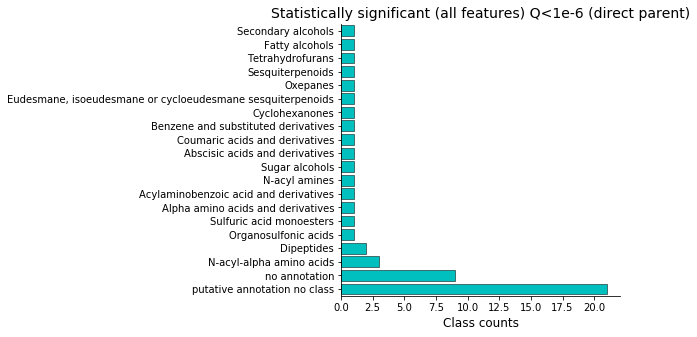

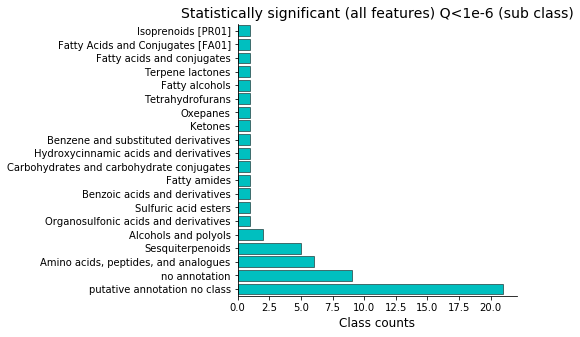

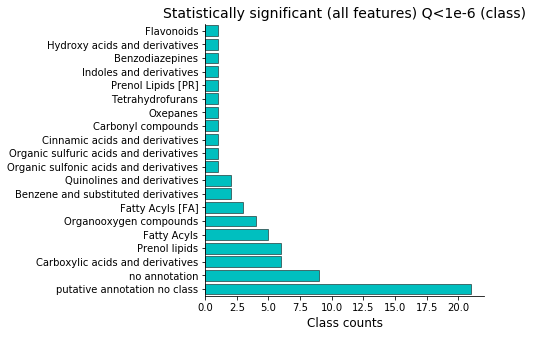

In [332]:
# peaks_data_og_with_metab
cols = stable_in_7.columns
sig = p<0.000001
# sig_ps = p[p<0.000001]
cols = cols[sig]
## look chemical classes    
title = 'Statistically significant (all features) Q<1e-6'
all_comp = list(peaks_data_og_with_metab.loc[list(cols),'metfrag_matched_best_guess'].values)
not_annot = [ele for ele in all_comp if 'Da/' in ele]
names_met_c,s_inds_met_c = get_names(list(cols), peaks_data_og_with_metab)
named_groups_met_c = names_lookup(names_met_c, dbs)
for pri,pri_class in zip(['last', 'middle', 'first'],['(direct parent)', '(sub class)', '(class)']):
    all_groups = {'no annotation':len(not_annot), 'putative annotation no class':0}
    for k,metab_groups in named_groups_met_c.items():
        if 'Da/' not in all_comp[k]:
            all_put_comps = ast.literal_eval(all_comp[k])
            if (len(all_put_comps) != 0 and len(metab_groups) == 0):
                all_groups['putative annotation no class']+= int(len(all_put_comps)-len(metab_groups))
        for sub_g in metab_groups:
            sub_g_class = get_best_name(sub_g, priority=pri)
            if sub_g_class not in all_groups:
                all_groups[sub_g_class] = 1
            else:
                all_groups[sub_g_class] += 1  
    all_groups = get_max_classes(all_groups,20)
    chart_metab_classes(all_groups, title, pri_class)
# peaks_data_og_with_metab.loc[cols][['mz','rt','metfrag_matched_best_guess']].to_csv('./unstable_feat_p_1e-3.csv')

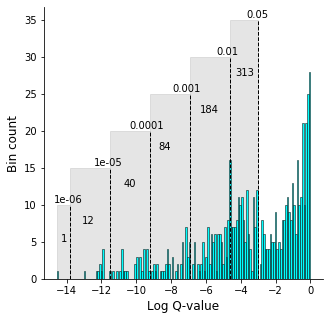

In [322]:
## justifying the p-value:
stable_in_7 = sorted_b_7[lt_all_3]
stable_in_61 = sorted_b_61[lt_all_3]
stable_in_84 = sorted_b_84[lt_all_3]
p_thresholds = [0.05, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
log_p_thresholds = np.log(p_thresholds)
# find the stat sig metabolites between the three with a K-W test - FDR corrected
p = np.zeros(stable_in_7.shape[1]) + np.nan
cols = stable_in_7.columns
for i,col in zip(range(stable_in_7.shape[1]),stable_in_7):
    _,p[i] = kruskal(stable_in_7[col], stable_in_61[col], stable_in_84[col])
_, p[~np.isnan(p)], _, _ = multipletests(p[~np.isnan(p)], alpha=0.00001, method='fdr_bh')
fig = plt.figure(figsize=(5,5))
ax = plt.subplot()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
heights = [10,15,20,25,30,35]
shifts = [-0.9,-0.9,-1.2,-1,-0.8,-0.7]
ll_rect = [np.log(p.min())] + [ele for ele in log_p_thresholds[1:]][::-1]
width_rect = [h-l for h,l in zip(log_p_thresholds[::-1],ll_rect)]

for thresh,pval,h,shift,ll,w in zip(log_p_thresholds,p_thresholds, heights[::-1], shifts[::-1],ll_rect[::-1], width_rect[::-1]):
    ax.plot([thresh,thresh],[0,h],'k--', linewidth=1.0)
    ax.text(thresh+shift,h+0.3,pval,fontname='sans-serif')
    ax.add_patch(Rectangle((ll,0),w,h, alpha=0.2, color='gray'))   
ax.set_xlabel('Log Q-value', fontname='sans-serif', fontsize=12)
ax.set_ylabel('Bin count', fontname='sans-serif', fontsize=12)

less_than_values = []
for p_threshold in p_thresholds:
    sig = p<p_threshold
    sig_ps = p[p<p_threshold]
    less_than_values.append(sig_ps.shape[0])
value_xs = [-4.3,-6.35,-8.75,-10.75,-13.1,-14.3]
value_ys = [5,7.5,12.5,17.5,22.5,27.5]
for x,y,val in zip(value_xs, value_ys[::-1], less_than_values):
    ax.text(x,y,val,fontname='sans-serif')
ax.hist(np.log(p), bins=150, facecolor='cyan', edgecolor='black', linewidth=0.5)
if save:
    plt.savefig('q-value_breakdown_with_counts_stable.svg', format='svg', dpi=1000, bbox_inches='tight')
plt.show()


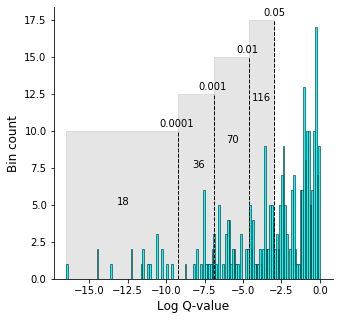

In [325]:
## same things but for the unstable features 
unstable_in_7 = sorted_b_7[gt_all_3]
unstable_in_61 = sorted_b_61[gt_all_3]
unstable_in_84 = sorted_b_84[gt_all_3]
p_thresholds = [0.05, 0.01, 0.001, 0.0001]
log_p_thresholds = np.log(p_thresholds)
# find the stat sig metabolites between the three with a K-W test - FDR corrected
p = np.zeros(unstable_in_7.shape[1]) + np.nan
cols = unstable_in_7.columns
for i,col in zip(range(unstable_in_7.shape[1]),unstable_in_7):
    _,p[i] = kruskal(unstable_in_7[col], unstable_in_61[col], unstable_in_84[col])
_, p[~np.isnan(p)], _, _ = multipletests(p[~np.isnan(p)], alpha=0.00001, method='fdr_bh')
fig = plt.figure(figsize=(5,5))
ax = plt.subplot()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
heights = [10,12.5,15,17.5]
shifts = [-0.9,-1.2,-1,-0.8,-0.7]
ll_rect = [np.log(p.min())] + [ele for ele in log_p_thresholds[1:]][::-1]
width_rect = [h-l for h,l in zip(log_p_thresholds[::-1],ll_rect)]

for thresh,pval,h,shift,ll,w in zip(log_p_thresholds,p_thresholds, heights[::-1], shifts[::-1],ll_rect[::-1], width_rect[::-1]):
    ax.plot([thresh,thresh],[0,h],'k--', linewidth=1.0)
    ax.text(thresh+shift,h+0.3,pval,fontname='sans-serif')
    ax.add_patch(Rectangle((ll,0),w,h, alpha=0.2, color='gray'))   
ax.set_xlabel('Log Q-value', fontname='sans-serif', fontsize=12)
ax.set_ylabel('Bin count', fontname='sans-serif', fontsize=12)

less_than_values = []
for p_threshold in p_thresholds:
    sig = p<p_threshold
    sig_ps = p[p<p_threshold]
    less_than_values.append(sig_ps.shape[0])
value_xs = [-4.4,-6.1,-8.3,-13.2]
value_ys = [5,7.5,9.2,12]
for x,y,val in zip(value_xs, value_ys[::-1], less_than_values):
    ax.text(x,y,val,fontname='sans-serif')
ax.hist(np.log(p), bins=150, facecolor='cyan', edgecolor='black', linewidth=0.5)
if save:
    plt.savefig('q-value_breakdown_with_counts_unstablefeat.svg', format='svg', dpi=1000, bbox_inches='tight')
plt.show()

(12,)
[69, 363, 460, 720, 967, 1021, 1291, 1387, 1484, 1608, 1652, 1720]


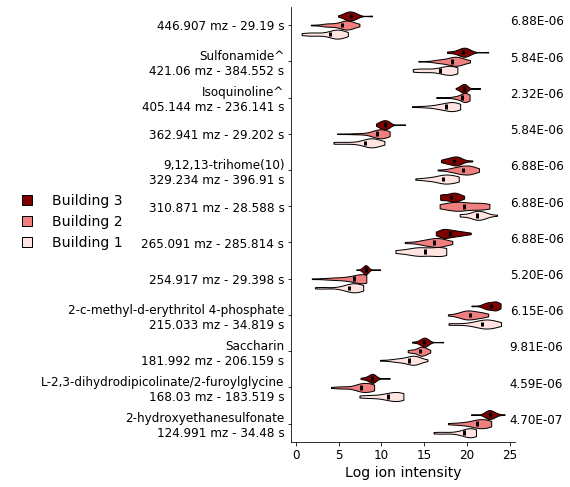

In [242]:
# find metabolites common to all three that are 'stable throughout' 
# but now find those with stat sig differences between the three buildings. 
# mask the building data by the stabile columns
stable_in_7 = sorted_b_7[lt_all_3]
stable_in_61 = sorted_b_61[lt_all_3]
stable_in_84 = sorted_b_84[lt_all_3]

# find the stat sig metabolites between the three with a K-W test - FDR corrected
p_threshold = 0.00001
p = np.zeros(stable_in_7.shape[1]) + np.nan
cols = stable_in_7.columns
for i,col in zip(range(stable_in_7.shape[1]),stable_in_7):
    _,p[i] = kruskal(stable_in_7[col], stable_in_61[col], stable_in_84[col])
_, p[~np.isnan(p)], _, _ = multipletests(p[~np.isnan(p)], alpha=p_threshold, method='fdr_bh')
sig = p<p_threshold
sig_ps = p[p<p_threshold]
cols = cols[sig]
print(sig_ps.shape)
# mask to get the important metabolites 
diff_stable_in_7 = stable_in_7[cols]
diff_stable_in_61 = stable_in_61[cols]
diff_stable_in_84 = stable_in_84[cols]
#### mask the peaks to get the mz features that are also interesting like this! 
peaks_diff_stable_b_7 = peaks_b_7_data_lt.loc[cols]
peaks_diff_stable_b_61 = peaks_b_61_data_lt.loc[cols]
peaks_diff_stable_b_84 = peaks_b_84_data_lt.loc[cols]
# ###### NOTE THE PEAKS ABOVE ARE ACTUALLY ALL THE SAME, so just use one in saving
if save: 
    diff_but_stable_all = pd.concat([diff_stable_in_7,diff_stable_in_61,diff_stable_in_84], axis=0)
    pd.concat([peaks_diff_stable_b_7,diff_but_stable_all.T,], axis=1).to_csv('./stable_but_diff_between_buildings_new.csv')

# plot all low variability data throughout but with differences between the buildings:
all_data = pd.concat([diff_stable_in_7, diff_stable_in_61, diff_stable_in_84],axis=0)
indicies_ = (all_data.columns)
intensity_values = []
positions = []
titles = []
tick_loc = [1,3,5,7,9,11,13,15,17,19,21,23]
print(list(diff_stable_in_7.columns))
for i,col in zip(tick_loc,diff_stable_in_7.columns):
    intensity_values.append(diff_stable_in_7[col].tolist())
    intensity_values.append(diff_stable_in_61[col].tolist())
    intensity_values.append(diff_stable_in_84[col].tolist())
    positions.append(i-0.5)
    positions.append(i)
    positions.append(i+0.5)
    # get the title if possible
    title = ''
    try:
        title_list = ast.literal_eval(peaks_data_og_with_metab.loc[col]['metfrag_matched_best_guess'])
        if float(title_list[0][1]) > 5.1:  
            pass
        else:
            for ele in title_list:
                title += ele[0]
                title += '/'
            if 'trihome' in title:
                title = '9,12,13-trihome(10)'
            if title[-1] == '/':
                title = title[:-1]
            if "N'-(3-chloro-2,4,6-trifluorophenyl)sulfonyl-1-adamantanecarbohydrazide" in title:
                title = 'sulfonamide^'
            if "2-[[2-[2-(2,3-dihydroindol-1-yl)-2-oxoethyl]-1-oxo-5-isoquinolinyl]oxy]acetic acid ethyl ester" in title:
                title = 'isoquinoline^'
            title += '\n'
        title += str(round(peaks_b_7_data_lt.loc[col]['mz'],3))
        title += ' mz - '
        title += str(round(peaks_b_7_data_lt.loc[col]['rt'],3))
        title += ' s'
    except:
        title = peaks_data_og_with_metab.loc[col]['metfrag_matched_best_guess']
        title = title.split('Da/')
        title = str(round(float(title[0]),3)) + ' mz - ' + str(round(float(title[1][:-1]),3)) + ' s'
    if '**' in title:
        title = title.replace('**','^')
    titles.append(title)
titles = [t[0].upper() + t[1:] for t in titles]
    
fig = plt.figure(figsize=(4,8))
ax1 = plt.subplot()
parts = ax1.violinplot(intensity_values, positions,vert=False, showmeans=True, showmedians=False, showextrema=False)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xlabel('Log ion intensity', fontname='sans-serif', fontsize=14)
ax1.set_ylim([0,24])
ax1.yaxis.set_ticks(tick_loc)
ax1.set_yticklabels(titles,  fontname='sans-serif', fontsize=12)
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(12)
    tick.label.set_fontname('sans-serif')
### set the colors - can change to a red if wanted
count = 0
for pc in parts['bodies']:
    if count % 3 ==0:
        pc.set_facecolor('mistyrose')
    elif count %3 == 1:
        pc.set_facecolor('lightcoral')
    else:
        pc.set_facecolor('maroon')
    count += 1
    pc.set_edgecolor('black')
    pc.set_alpha(1) 
for partname in ['cmeans']:
    vp = parts[partname]
    vp.set_edgecolor('k')
    vp.set_linewidth(3)
for s, y in zip(sig_ps, tick_loc):
    ax1.text(25,y, '{:.2E}'.format(s),  fontname='sans-serif', fontsize=12)
legend_data = [['Building 3', 'maroon', 'k', 's'],
               ['Building 2', 'lightcoral', 'k', 's'],
               ['Building 1', 'mistyrose', 'k', 's']]
patches_bar = []
for ele in legend_data:
    patches_bar.append(Line2D([0],[0], color='w', marker=ele[3],markerfacecolor=ele[1], markeredgecolor=ele[2], label=ele[0], markersize=10)) 
font = font_manager.FontProperties(family='sans-serif', style='normal', size=14)
lgd = ax1.legend(handles=patches_bar, bbox_to_anchor=(-.7, 0.6), frameon=False, prop=font)
plt.savefig('Fig2c_new.svg', format='svg', dpi=1000, bbox_inches='tight')

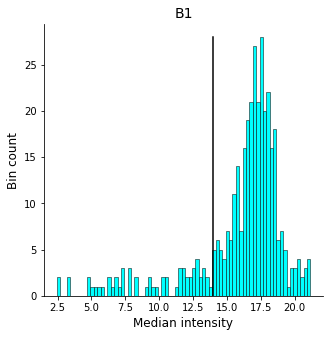

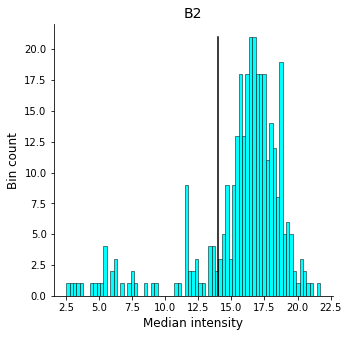

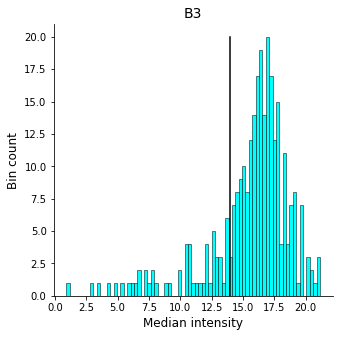

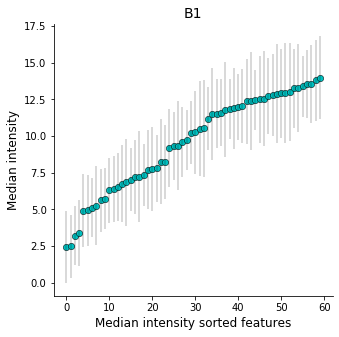

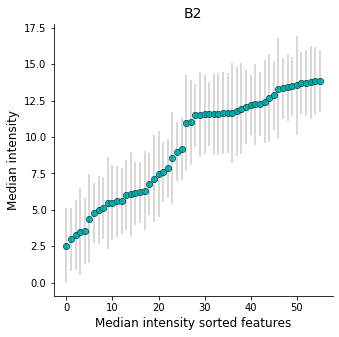

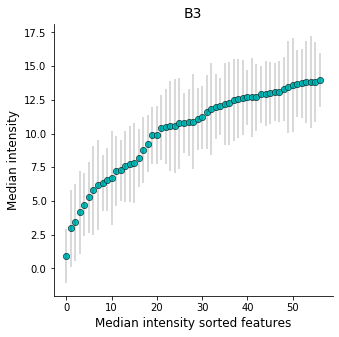

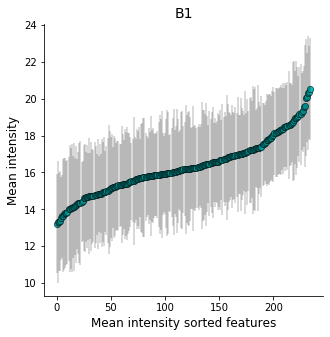

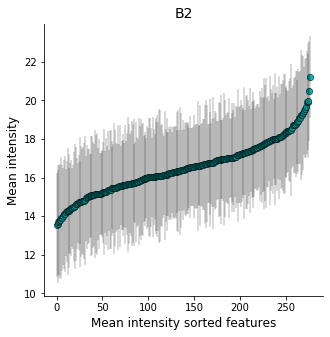

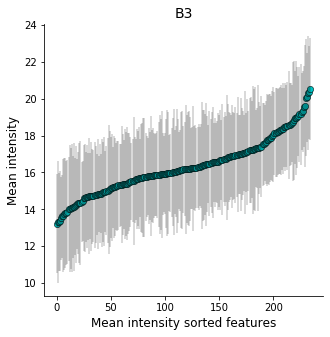

In [75]:
# find metabolites common to all three that are 'not stable throughout' 
# and also the converse, of those that are not stable throughout, which are not stat sig. 
# but now find those with stat sig differences between the three buildings. 

### can we get all data with matching datas and find time courses that are similar and different ...euclidean distance...
if processed:
    # get only metabolites above the threshold and shared by all three
    not_stable_in_7 = sorted_b_7[gt_all_3]
    not_stable_in_61 = sorted_b_61[gt_all_3]
    not_stable_in_84 = sorted_b_84[gt_all_3]
else:
    #### for building the df in the next box use the following as it get the exact types for all metabs, not just shared:
    not_stable_in_7 = sorted_b_7[gt_d1_n + gt_d1_2 + gt_d1_3 + gt_all_3]
    not_stable_in_61 = sorted_b_61[gt_d2_n + gt_d1_2 + gt_d2_3 + gt_all_3]
    not_stable_in_84 = sorted_b_84[gt_d3_n + gt_d2_3 + gt_d1_3 + gt_all_3]

high_var = 3.5
#################
### FYI: 'high fliers' = Class 2, 'bottom feeders' = Class 1, 'Selective attenders' = Class 3 lol
#################
### pull out time courses with largest STD  
### 'high fliers'
high_fly_b_84 = not_stable_in_84[not_stable_in_84.columns[not_stable_in_84.std(axis=0) > high_var]]
high_fly_b_61 = not_stable_in_61[not_stable_in_61.columns[not_stable_in_61.std(axis=0) > high_var]]
high_fly_b_7 = not_stable_in_7[not_stable_in_7.columns[not_stable_in_7.std(axis=0) > high_var]]
### remove these samples to not double count later:
not_stable_in_84_mod = not_stable_in_84.drop(columns=list(high_fly_b_84.columns))
not_stable_in_61_mod = not_stable_in_61.drop(columns=list(high_fly_b_61.columns))
not_stable_in_7_mod = not_stable_in_7.drop(columns=list(high_fly_b_7.columns))
### 'Bottom feeders'
median_stable=14
b_84_m = not_stable_in_84_mod.median()
b_61_m = not_stable_in_61_mod.median()
b_7_m = not_stable_in_7_mod.median()
for b_meds,name in zip([b_7_m,b_61_m,b_84_m],['B1', 'B2','B3']):
    fig = plt.figure(figsize=(5,5))
    ax = plt.subplot()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel('Median intensity', fontname='sans-serif', fontsize=12)
    ax.set_ylabel('Bin count', fontname='sans-serif', fontsize=12)
    ax.set_title(name, fontname='sans-serif', fontsize=14)
    n,_,_ = plt.hist(b_meds,bins=75,facecolor='cyan', edgecolor='black', linewidth=0.5)
    plt.plot([median_stable,median_stable],[0,n.max()], 'k-')
    if save:
        plt.savefig('low_median_int_highvarrem_{}.svg'.format(name), format='svg', dpi=1000, bbox_inches='tight')
    plt.show()
    
med_lt = median_stable
bottom_feed_b_84 = not_stable_in_84_mod[not_stable_in_84_mod.columns[not_stable_in_84_mod.median(axis=0) <= med_lt]]
bottom_feed_b_61 = not_stable_in_61_mod[not_stable_in_61_mod.columns[not_stable_in_61_mod.median(axis=0) <= med_lt]]
bottom_feed_b_7 = not_stable_in_7_mod[not_stable_in_7_mod.columns[not_stable_in_7_mod.median(axis=0) <= med_lt]]
b_84_m = bottom_feed_b_84.median()
b_61_m = bottom_feed_b_61.median()
b_7_m = bottom_feed_b_7.median()
b_84_s = bottom_feed_b_84.std()
b_61_s = bottom_feed_b_61.std()
b_7_s = bottom_feed_b_7.std()
for b_meds,b_std, name in zip([b_7_m,b_61_m,b_84_m],[b_7_s,b_61_s,b_84_s],['B1', 'B2','B3']):
    b_meds = b_meds.values
    b_std = b_std.values
    inds = np.argsort(b_meds)
    b_meds = b_meds[inds]
    b_std = b_std[inds]
    fig = plt.figure(figsize=(5,5))
    ax = plt.subplot()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel('Median intensity sorted features', fontname='sans-serif', fontsize=12)
    ax.set_ylabel('Median intensity', fontname='sans-serif', fontsize=12)
    ax.set_title(name, fontname='sans-serif', fontsize=14)
    ax.scatter([i for i in range(b_meds.shape[0])],b_meds,s=40, c='c', edgecolor='k', linewidth=0.5)
    ax.errorbar([i for i in range(b_meds.shape[0])],b_meds,yerr=b_std, ecolor='k', elinewidth=0.3, fmt='none')   
    if save:
        plt.savefig('low_median_int_with_std_{}.svg'.format(name), format='svg', dpi=1000, bbox_inches='tight')
    plt.show() 

not_stable_in_84_mod = not_stable_in_84_mod.drop(columns=list(bottom_feed_b_84.columns))
not_stable_in_61_mod = not_stable_in_61_mod.drop(columns=list(bottom_feed_b_61.columns))
not_stable_in_7_mod = not_stable_in_7_mod.drop(columns=list(bottom_feed_b_7.columns))
high_bottom_84 = list(set(sorted(list(high_fly_b_84)+list(bottom_feed_b_84))))
high_bottom_61 = list(set(sorted(list(high_fly_b_61)+list(bottom_feed_b_61))))
high_bottom_7 = list(set(sorted(list(high_fly_b_7)+list(bottom_feed_b_7))))
### 'Selective attenders'
sel_attend_b_84 = not_stable_in_84_mod[[ele for ele in list(not_stable_in_84_mod) if ele not in high_bottom_84]]
sel_attend_b_61 = not_stable_in_61_mod[[ele for ele in list(not_stable_in_61_mod) if ele not in high_bottom_61]]
sel_attend_b_7 = not_stable_in_7_mod[[ele for ele in list(not_stable_in_7_mod) if ele not in high_bottom_7]]
b_84_m = sel_attend_b_84.mean()
b_61_m = sel_attend_b_61.mean()
b_7_m = sel_attend_b_84.mean()
b_84_s = sel_attend_b_84.std()
b_61_s = sel_attend_b_61.std()
b_7_s = sel_attend_b_84.std()

for b_mean,b_std, name in zip([b_7_m,b_61_m,b_84_m],[b_7_s,b_61_s,b_84_s],['B1', 'B2','B3']):
    b_mean = b_mean.values
    b_std = b_std.values
    inds = np.argsort(b_mean)
    b_mean = b_mean[inds]
    b_std = b_std[inds]
    fig = plt.figure(figsize=(5,5))
    ax = plt.subplot()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel('Mean intensity sorted features', fontname='sans-serif', fontsize=12)
    ax.set_ylabel('Mean intensity', fontname='sans-serif', fontsize=12)
    ax.set_title(name, fontname='sans-serif', fontsize=14)
    ax.scatter([i for i in range(b_mean.shape[0])],b_mean,s=40, c='c', edgecolor='k', linewidth=0.5)
    ax.errorbar([i for i in range(b_mean.shape[0])],b_mean,yerr=b_std, ecolor='k', elinewidth=0.3, fmt='none')   
    if save:
        plt.savefig('mid_mean_int_mid_std_{}.svg'.format(name), format='svg', dpi=1000, bbox_inches='tight')
    plt.show()

In [76]:
#### question: for the metabolites with high variance in all buildings, how are they different building to building
### 1) group the 3 'classes' above 
### 3 buildings, 3 groups...whats shared in each group between buildings...?
### then once you know whats in common you get a list of what NOT in all 3 building in the same category
### here you find interesting metabolites, ie perhaps 2 are bottom feeders and 1 is a high flier.... etc
###### selective attenders 
sel_attend_b_7_names = list(sel_attend_b_7)
sel_attend_b_61_names = list(sel_attend_b_61)
sel_attend_b_84_names = list(sel_attend_b_84)
combined = list(set(sel_attend_b_7_names) & set(sel_attend_b_61_names) & set(sel_attend_b_84_names))
sel_attend_not_shared = {'B-7':[],'B-61':[],'B-84':[]}
for building, l in zip(['B-7','B-61','B-84'],[sel_attend_b_7_names, sel_attend_b_61_names, sel_attend_b_84_names]):
    for col in l:
        if col not in combined:
            sel_attend_not_shared[building].append(col)          
print('total combined: ', len(combined), 'total sel attend 7: ', len(sel_attend_b_7_names),
     'total sel attend 61: ', len(sel_attend_b_61_names), 'total sel attend 84: ', len(sel_attend_b_84_names))
print('sa',combined)
###### bottom feeders 
bottom_feed_b_7_names = list(bottom_feed_b_7)
bottom_feed_b_61_names = list(bottom_feed_b_61)
bottom_feed_b_84_names = list(bottom_feed_b_84)
combined = list(set(bottom_feed_b_7_names) & set(bottom_feed_b_61_names) & set(bottom_feed_b_84_names))
bottom_feed_not_shared = {'B-7':[],'B-61':[],'B-84':[]}
for building, l in zip(['B-7','B-61','B-84'],[bottom_feed_b_7_names, bottom_feed_b_61_names, bottom_feed_b_84_names]):
    for col in l:
        if col not in combined:
            bottom_feed_not_shared[building].append(col)
print('total combined: ', len(combined), 'total bottom feeder 7: ', len(bottom_feed_b_7_names),
     'total bottom feeder 61: ', len(bottom_feed_b_61_names), 'total bottom feeder 84: ', len(bottom_feed_b_84_names))
print('bf',combined)
###### high fliers
high_fly_b_7_names = list(high_fly_b_7)
high_fly_b_61_names = list(high_fly_b_61)
high_fly_b_84_names = list(high_fly_b_84)
combined = list(set(high_fly_b_7_names) & set(high_fly_b_61_names) & set(high_fly_b_84_names))
high_fly_not_shared = {'B-7':[],'B-61':[],'B-84':[]}
for building, l in zip(['B-7','B-61','B-84'],[high_fly_b_7_names, high_fly_b_61_names, high_fly_b_84_names]):
    for col in l:
        if col not in combined:
            high_fly_not_shared[building].append(col)
print('total combined: ', len(combined), 'total high flier 7: ', len(high_fly_b_7_names),
     'total high flier 61: ', len(high_fly_b_61_names), 'total high flier 84: ', len(high_fly_b_84_names))
print('hf',combined)


total combined:  42 total sel attend 7:  310 total sel attend 61:  278 total sel attend 84:  235
sa [1282, 1924, 1802, 2061, 1805, 2191, 1168, 2065, 2194, 1936, 1176, 1945, 1052, 1054, 1313, 1060, 169, 2097, 178, 2101, 1719, 1721, 825, 1724, 1726, 1987, 1865, 1746, 1109, 2137, 2139, 2143, 2148, 2149, 2020, 2025, 2155, 2028, 2158, 2162, 2037, 1917]
total combined:  15 total bottom feeder 7:  60 total bottom feeder 61:  56 total bottom feeder 84:  57
bf [64, 1219, 810, 1452, 428, 173, 239, 692, 1365, 2166, 1626, 187, 1725, 542, 895]
total combined:  77 total high flier 7:  264 total high flier 61:  236 total high flier 84:  165
hf [1025, 1794, 898, 1540, 1412, 518, 1031, 647, 775, 1800, 778, 1290, 397, 1550, 401, 786, 1939, 788, 1818, 795, 1434, 1565, 1438, 1186, 1314, 1406, 1190, 1830, 1320, 1448, 425, 557, 1198, 1586, 1715, 1588, 1717, 1462, 184, 696, 188, 702, 1090, 1218, 1477, 198, 71, 2121, 716, 717, 849, 1490, 1621, 729, 1245, 862, 1119, 477, 1121, 2014, 2147, 612, 1507, 485, 503, 

In [77]:
## adding for each building the type of unstable metab if its an unstable metab, otherwise 'stable'
sa_int = [1282, 1924, 1802, 2061, 1805, 2191, 1168, 2065, 1936, 1429, 2198, 1176, 1945, 1052, 1054, 1313, 1060, 
          422, 169, 178, 2101, 1719, 1721, 826, 1724, 1726, 1987, 1865, 1746, 1749, 2139, 2143, 2015, 2148, 871,
          2152, 2025, 1392, 2162, 2037]
bf_int = [64, 322, 1219, 810, 1452, 428, 173, 239, 241, 1365, 2166, 1626, 1725, 542, 895] 
hf_int = [1540, 1412, 518, 1031, 647, 775, 1800, 778, 1290, 397, 1421, 786, 1939, 1818, 795, 1434, 1565, 1438,
          673, 2082, 1186, 1314, 1406, 1190, 1830, 1320, 1448, 425, 557, 1198, 1586, 1715, 1588, 1717, 184, 696,
          702, 1218, 1477, 198, 71, 2121, 1490, 729, 1245, 2014, 1119, 1121, 2147, 612, 1507, 485, 503, 1386,
          1133, 1262, 493, 625, 1010, 630, 631, 1402, 891, 1662, 1407]

if not processed:
    null_name_list = ['stable' for i in range(peaks_data_og_with_metab.shape[0])]
    peaks_data_og_with_metab['unstable_type_b7'] = null_name_list
    peaks_data_og_with_metab['unstable_type_b61'] = null_name_list
    peaks_data_og_with_metab['unstable_type_b84'] = null_name_list
    all_bottom_feeders = [bottom_feed_b_7_names, bottom_feed_b_61_names, bottom_feed_b_84_names]
    all_sel_attend = [sel_attend_b_7_names, sel_attend_b_61_names, sel_attend_b_84_names]
    all_high_fliers = [high_fly_b_7_names, high_fly_b_61_names, high_fly_b_84_names]
    building_names = ['unstable_type_b7', 'unstable_type_b61', 'unstable_type_b84']

    all_types = [all_bottom_feeders, all_sel_attend, all_high_fliers]
    type_names = ['bottom_feeder', 'selective_attender', 'high_flier']

    for metab_type_buildings, type_name in zip(all_types, type_names):
        for building, locations in zip(building_names, metab_type_buildings):
            peaks_data_og_with_metab.loc[locations, building] = type_name
            

14


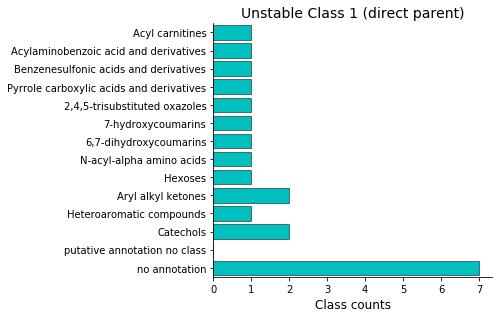

14


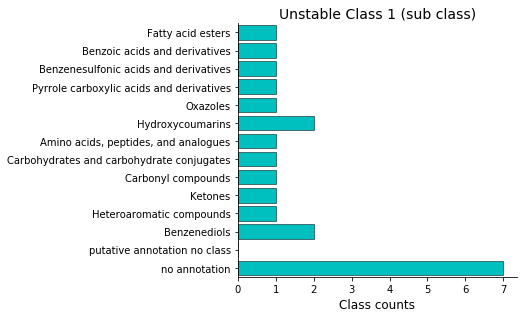

12


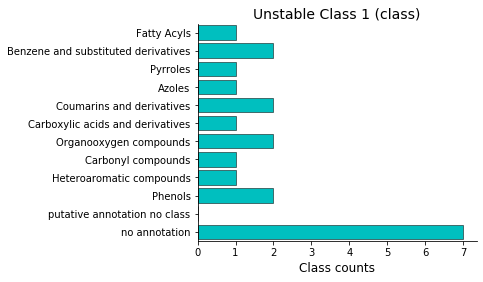

25


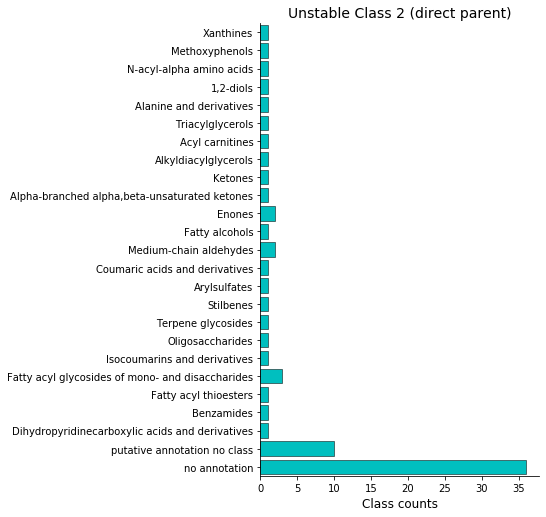

22


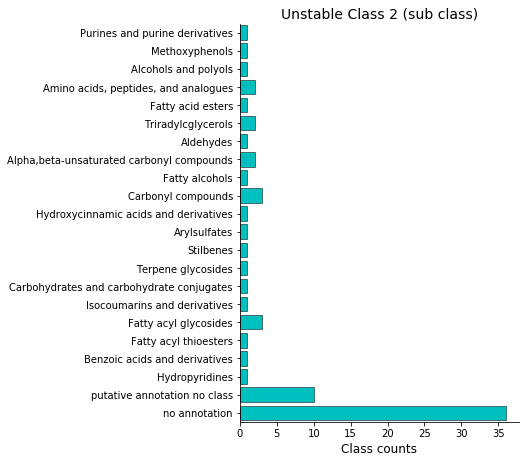

16


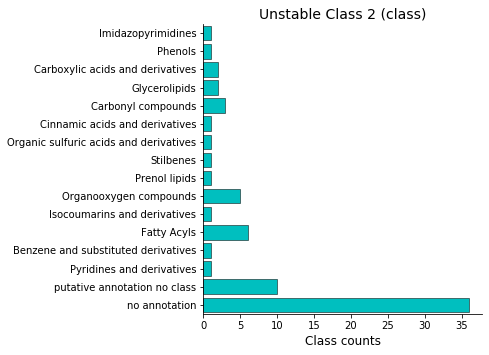

11


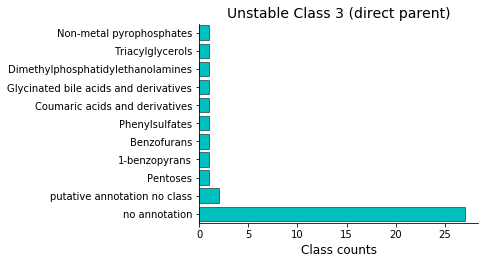

11


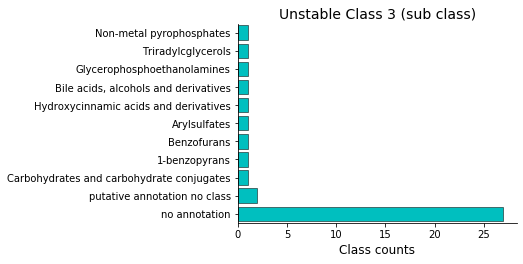

11


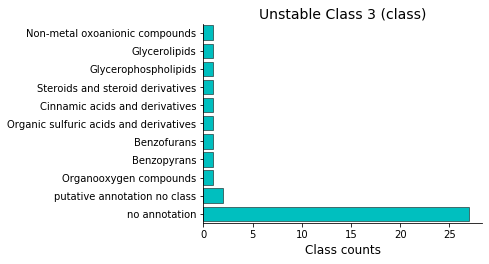

In [155]:
def chart_metab_classes(class_to_count, title, priority):
    heights = list(class_to_count.values())
    labels = list(class_to_count.keys())
    x = [i for i in range(len(labels))]
    print(len(labels))
    fig = plt.figure(figsize=(5,0.333*len(labels)))
    ax = plt.subplot()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel('Class counts', fontname='sans-serif', fontsize=12)
    ax.set_title(title+ ' '+priority, fontname='sans-serif', fontsize=14)
    ax.barh(x, heights,color='c', edgecolor='k', linewidth=0.5)
    ax.set_yticks(x)
    ax.set_yticklabels(labels)
    ax.set_ylim([-0.5,len(labels)-0.5])
    if save:
        plt.savefig('metab_types_{}_{}.svg'.format('_'.join(title.split(' ')),'_'.join(priority.split(' '))), format='svg', dpi=1000, bbox_inches='tight')
    plt.show()
    
    
for title, met_class in zip(['Unstable Class 1', 'Unstable Class 2', 'Unstable Class 3'],[bf_int, hf_int,sa_int]):
    all_comp = list(peaks_data_og_with_metab.loc[met_class,'metfrag_matched_best_guess'].values)
    not_annot = [ele for ele in all_comp if 'Da/' in ele]
    stable_names_met_c,s_inds_met_c = get_names(met_class, peaks_data_og_with_metab)
    stable_named_groups_met_c = names_lookup(stable_names_met_c, dbs)
    for pri,pri_class in zip(['last', 'middle', 'first'],['(direct parent)', '(sub class)', '(class)']):
        met_c_metab_classes = []
        all_groups = {'no annotation':len(not_annot), 'putative annotation no class':0}
        for k,metab_groups in stable_named_groups_met_c.items():
            if 'Da/' not in all_comp[k]:
                all_put_comps = ast.literal_eval(all_comp[k])
                if (len(all_put_comps) != 0 and len(metab_groups) == 0):
                    all_groups['putative annotation no class']+= int(len(all_put_comps)-len(metab_groups))
            for sub_g in metab_groups:
                sub_g_class = get_best_name(sub_g, priority=pri)
                if sub_g_class not in all_groups:
                    all_groups[sub_g_class] = 1
                else:
                    all_groups[sub_g_class] += 1     
        chart_metab_classes(all_groups, title, pri_class)


In [264]:
def sort_date(month_df, sorted_df):
    month_dates = list(month_df.index)
    dates = []
    for date in month_dates:
        d = date.strip().split('B')[0]
        smaller_d = int(d.split('_')[1][1:])
        dates.append((smaller_d,date))
    names = sorted(dates, key=lambda x: x[0])
    sorted_date_names = [n[1] for n in names]
    sorted_month_df = month_df.loc[sorted_date_names]
    sorted_df.append(sorted_month_df)
    return sorted_df
def sort_month(unsorted_df):
    '''
    need o then n then d
        then inside each of these sort by date
    '''
    name_list = list(unsorted_df.index)
    oct_names = [name for name in name_list if 'O' in name]
    nov_names = [name for name in name_list if 'N' in name]
    dec_names = [name for name in name_list if 'D' in name]
    sorted_df_list = []
    for month in [oct_names, nov_names, dec_names]:
        sorted_df_list = sort_date(unsorted_df.loc[month], sorted_df_list)
    return pd.concat(sorted_df_list)


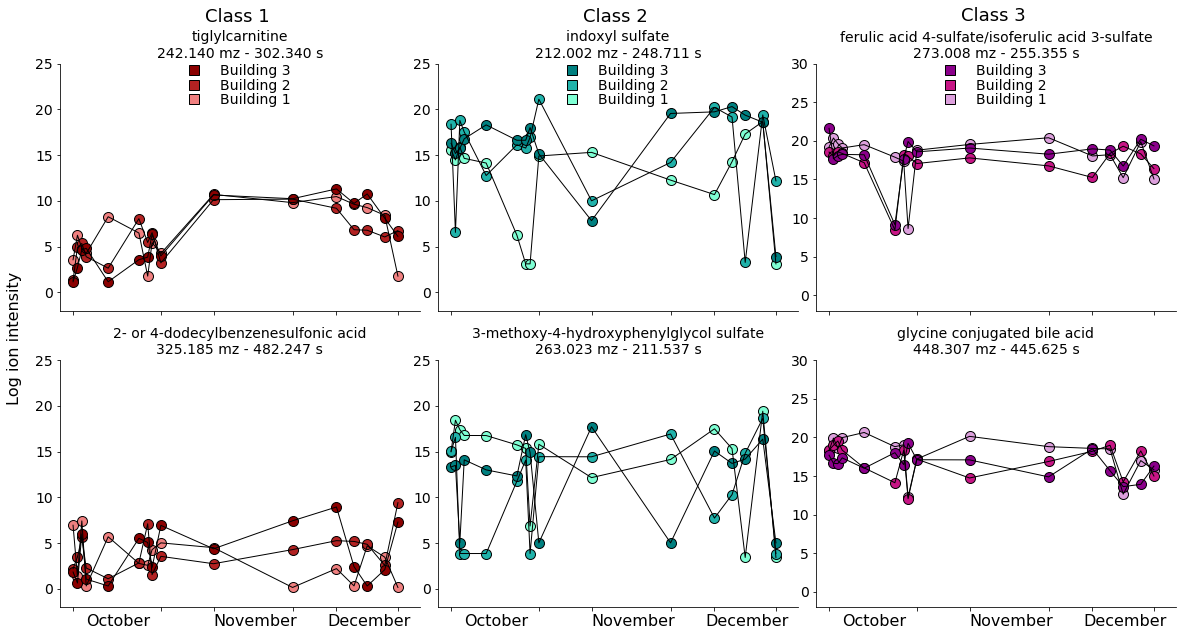

In [278]:
### find and then plot example time courses for the 3 metabolite types - not Z-normalized!
#### first look through to find examples where all 3 types match and then there is also a metfrag best matched name with:
#### peaks_data_og_with_metab[['mz','rt','metfrag_matched_best_guess','unstable_type_b7','unstable_type_b61','unstable_type_b84']]
# hf = [26,277,464,1032,1190,1234,1314,1421,1538,1724,1745]
# bf = [82, 430, 536]
# sa = [367,377,397,557,612,627,702,715,759,767,786,788,825,898] # 397,557, 1010
## now make nice plots with two from each of the types with data in each plot of all three buildings
## ie a 2,3 plot where each sub plot has 3 time courses plotted
def process_dataset(df):
    ind = list(df.index)
    ind = {ele:ele.split('B')[0] for ele in ind}
    df = df.rename(index=ind)
    ind_df = set(df.index)
    return df, ind_df

sorted_b_7, ind_7 = process_dataset(sorted_b_7)
sorted_b_61, ind_61 = process_dataset(sorted_b_61)
sorted_b_84, ind_84 = process_dataset(sorted_b_84)
common = list(ind_7 & ind_61 & ind_84)

sorted_b_7 = sorted_b_7.loc[common]
sorted_b_61 = sorted_b_61.loc[common]
sorted_b_84 = sorted_b_84.loc[common]

sorted_b_7 = sort_month(sorted_b_7)
sorted_b_61 = sort_month(sorted_b_61)
sorted_b_84 = sort_month(sorted_b_84)

def plot_single_ts(ax, index, title, mz, rt,i):
    title = ast.literal_eval(title)
    title = [ele[0] for ele in title]
    ylim = [-2,25]
    if i == 0 or i ==1 :
        colors = ['lightcoral', 'firebrick', 'darkred']
    elif i == 2 or i == 3:
        colors = ['aquamarine', 'lightseagreen', 'teal']
    else:
        colors = ['plum', 'mediumvioletred','darkmagenta']
        ylim = [-2,30]
    if 'deoxycholic acid' in title[0]:
        title = ['glycine conjugated bile acid']
    if 'dodecyl' in title[0]:
        title = ['2- or 4-dodecylbenzenesulfonic acid']
    if 'indoxyl sulfate' in title:
        title = ['indoxyl sulfate']
    if len(title) > 3:
        title = 'Multiple matches see SI'+ '\n' +'{:.3f} mz - {:.3f} s'.format(mz, rt)
    else:
        title = '/'.join(title) + '\n' +'{:.3f} mz - {:.3f} s'.format(mz, rt)
    
    ax.set_title(title,fontname='sans-serif', fontsize=14)
    if i in [0,2,4]:
        legend_data = [['Building 3', colors[2], 'k', 's'],
                       ['Building 2', colors[1], 'k', 's'],
                       ['Building 1', colors[0], 'k', 's']]
        patches_bar = []
        for ele in legend_data:
            patches_bar.append(Line2D([0],[0], color='w', marker=ele[3],markerfacecolor=ele[1], markeredgecolor=ele[2], label=ele[0], markersize=10)) 
        font = font_manager.FontProperties(family='sans-serif', style='normal', size=14)
        lgd = ax.legend(handles=patches_bar, bbox_to_anchor=(0.675, 1.05), frameon=False, prop=font,labelspacing=0.05)
    for b_ts, c in zip([sorted_b_7, sorted_b_61, sorted_b_84], colors):
        ax.scatter([1,2,3,4,9,16,18,19,21,33,51,61,65,68,72,75], b_ts[index], c=c, s=100, edgecolor='k')
        ax.plot([1,2,3,4,9,16,18,19,21,33,51,61,65,68,72,75], b_ts[index], 'k', linewidth=1)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_xticks([1,21,33,51,61,75])
        ax.set_xticklabels([])
        ax.set_ylim(ylim)
        ax.set_xlim([-2,80])
        for label in (ax.get_yticklabels()):
            label.set_fontsize(14)
            label.set_fontname('sans-serif')
        for label in (ax.get_xticklabels()):
            label.set_fontsize(14)
            label.set_fontname('sans-serif')
        
def plot_time_series_different_types(indicies):
    fig = plt.figure(figsize=(20,10))
    gs = GridSpec(2,3, figure=fig,wspace=0.05,hspace=0.2)
    seen = []
    j=0
    titles = list(peaks_data_og_with_metab.loc[indicies]['metfrag_matched_best_guess'])
    mzs = list(peaks_data_og_with_metab.loc[indicies]['mz'])
    rts = list(peaks_data_og_with_metab.loc[indicies]['rt'])
    for i, ind, title,mz,rt in zip([0,1,2,3,4,5],indicies, titles, mzs, rts):
        
        if i % 2 == 0:
            ax = plt.subplot(gs[:1, j:j+1])
            if i == 4:
                ax.text(31, 35.5, 'Class {}'.format(j+1),fontname='sans-serif', fontsize=18)
            else:
                ax.text(31, 29.5, 'Class {}'.format(j+1),fontname='sans-serif', fontsize=18)
        else:
            ax = plt.subplot(gs[1:2, j:j+1])
            j+=1
            lab_delta = -4
            if i == 5:
                lab_delta -= 0.4
            ax.text(4,lab_delta,'October',fontname='sans-serif', fontsize=16)
            ax.text(33,lab_delta,'November', fontname='sans-serif', fontsize=16)
            ax.text(59,lab_delta,'December', fontname='sans-serif', fontsize=16)
        if i == 0:
            ax.text(-14,-12,'Log ion intensity',fontname='sans-serif', fontsize=16, rotation=90)
        plot_single_ts(ax,ind, title, mz, rt,i)
    plt.savefig('Fig2_d_new.svg', format='svg', dpi=1000, bbox_inches='tight')

plot_time_series_different_types([895,1365,702,1010,1060,1724])
# 64, 322, 1219, 810, 1452, 428, 173, 239, 241, 1365, 2166, 1626, 1725, 542, 895

In [105]:
if save: 
    print('saving')
    peaks_data_og_with_metab.to_csv('./stability_added_partly_cleaned_metals_combined_mz_rt_metfrag_votes_isotopes_mzrt_noname_new.csv')   

saving


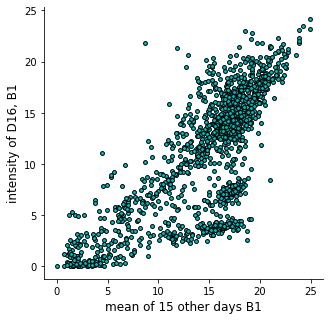

In [294]:
## looking at ion intensity across the buildings across the sampels       
# for b in [sorted_b_7,sorted_b_61,sorted_b_84]:
#     fig = plt.figure(figsize=(10,5))
#     ax = plt.subplot()
#     b_data = []
#     for ind, row in b.iterrows():
#         b_data.append(row.values)
#     ax.violinplot(b_data,showmeans=False, showmedians=True, showextrema=False)

    #### look at a per feature 
first_part = sorted_b_7.iloc[:-1,:].mean(axis=0)
first_part_std = sorted_b_7.iloc[:-1,:].std(axis=0)
last_d = sorted_b_7.iloc[-1,:]
# delta = abs(first_part-last_d)
# delta = delta[delta>first_part_std]
# delta = sorted(delta)
# plt.hist(delta, bins=50)
fig = plt.figure(figsize=(5,5))
ax = plt.subplot()
ax.scatter(first_part,last_d, c='c', s=15, edgecolor='k')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('mean of 15 other days B1', fontname='sans-serif', fontsize=12)
ax.set_ylabel('intensity of D16, B1',fontname='sans-serif', fontsize=12)
if save:
    plt.savefig('int_D16_v_rest_B1.svg', format='svg', dpi=1000, bbox_inches='tight')
plt.show()